In [28]:
# ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏
import pandas as pd
import numpy as np
import glob
import os
import re
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
# Í∏∞Í≥ÑÌïôÏäµ ÎùºÏù¥Î∏åÎü¨Î¶¨
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split as sklearn_train_test_split  # Î≥ÑÏπ≠ ÏÇ¨Ïö©
from surprise import Dataset, Reader, SVD, KNNBasic, NMF, BaselineOnly
from surprise.model_selection import cross_validate, train_test_split as surprise_train_test_split  # Î≥ÑÏπ≠ ÏÇ¨Ïö©
from surprise import accuracy
from collections import defaultdict
import sys
import warnings
warnings.filterwarnings('ignore')

# ÌïúÍµ≠Ïñ¥ Ìè∞Ìä∏ ÏÑ§Ï†ï (ÏãúÏä§ÌÖúÏóê Îî∞Îùº Ï°∞Ï†ï ÌïÑÏöî)
plt.rcParams['font.family'] = ['Malgun Gothic', 'AppleGothic', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False


# Ï†ÑÏó≠ Î≥ÄÏàò ÏÑ§Ï†ï
data = None
trainset = None
testset = None
algorithms = {}
results = {}

print("ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏ ÏôÑÎ£å")
print(f"Python Î≤ÑÏ†Ñ: {sys.version}")
print(f"Pandas Î≤ÑÏ†Ñ: {pd.__version__}")
print(f"NumPy Î≤ÑÏ†Ñ: {np.__version__}")
print(f"Matplotlib Î≤ÑÏ†Ñ: {plt.matplotlib.__version__}")
print(f"Seaborn Î≤ÑÏ†Ñ: {sns.__version__}")


ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏ ÏôÑÎ£å
Python Î≤ÑÏ†Ñ: 3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]
Pandas Î≤ÑÏ†Ñ: 1.5.3
NumPy Î≤ÑÏ†Ñ: 1.23.5
Matplotlib Î≤ÑÏ†Ñ: 3.7.0
Seaborn Î≤ÑÏ†Ñ: 0.12.2


In [ ]:
# Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ìï®Ïàò
def load_recommendation_data(ratings_file):
    global data, trainset, testset
    
    # ratings.dat ÌååÏùº ÌòïÏãù: UserID::MovieID::Rating::Timestamp
    ratings_df = pd.read_csv(
        ratings_file, 
        sep='::', 
        names=['user_id', 'movie_id', 'rating', 'timestamp'],
        engine='python'
    )
    
    print(f"Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: {len(ratings_df):,}Í∞úÏùò ÌèâÏ†ê")
    print(f"ÏÇ¨Ïö©Ïûê Ïàò: {ratings_df['user_id'].nunique():,}Î™Ö")
    print(f"ÏòÅÌôî Ïàò: {ratings_df['movie_id'].nunique():,}Í∞ú")
    print(f"ÌèâÏ†ê Î∂ÑÌè¨:\n{ratings_df['rating'].value_counts().sort_index()}")
        
    # Surprise ÎùºÏù¥Î∏åÎü¨Î¶¨Ïö© Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(ratings_df[['user_id', 'movie_id', 'rating']], reader)
        
    # 80:20 ÎπÑÏú®Î°ú Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† (surprise ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏÇ¨Ïö©)
    trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)
        
    return ratings_df

# ÏïåÍ≥†Î¶¨Ï¶ò Ï¥àÍ∏∞Ìôî Ìï®Ïàò
def initialize_algorithms():
    """Ï∂îÏ≤ú ÏïåÍ≥†Î¶¨Ï¶ò Ï¥àÍ∏∞Ìôî"""
    global algorithms
    
    algorithms = {
        'SVD': SVD(n_factors=100, n_epochs=20, random_state=42),
        'KNNBasic': KNNBasic(k=40, sim_options={'name': 'cosine', 'user_based': True}),
        'NMF': NMF(n_factors=50, n_epochs=50, random_state=42),
        'BaselineOnly': BaselineOnly()
    }
        
    print(f"Ï¥àÍ∏∞ÌôîÎêú ÏïåÍ≥†Î¶¨Ï¶ò: {list(algorithms.keys())}")

# Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è ÏïåÍ≥†Î¶¨Ï¶ò Ï¥àÍ∏∞Ìôî Ïã§Ìñâ
print("=== MovieLens 1M Îç∞Ïù¥ÌÑ∞ Î°úÎìú ===")
ratings_df = load_recommendation_data('ratings.dat')
print("\n=== ÏïåÍ≥†Î¶¨Ï¶ò Ï¥àÍ∏∞Ìôî ===")
initialize_algorithms()


=== MovieLens 1M Îç∞Ïù¥ÌÑ∞ Î°úÎìú ===
Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: 1,000,209Í∞úÏùò ÌèâÏ†ê
ÏÇ¨Ïö©Ïûê Ïàò: 6,040Î™Ö
ÏòÅÌôî Ïàò: 3,706Í∞ú
ÌèâÏ†ê Î∂ÑÌè¨:
1     56174
2    107557
3    261197
4    348971
5    226310
Name: rating, dtype: int64

=== ÏïåÍ≥†Î¶¨Ï¶ò Ï¥àÍ∏∞Ìôî ===
Ï¥àÍ∏∞ÌôîÎêú ÏïåÍ≥†Î¶¨Ï¶ò: ['SVD', 'KNNBasic', 'NMF', 'BaselineOnly']


In [6]:
# 5-Ìè¥Îìú ÍµêÏ∞® Í≤ÄÏ¶ù ÌèâÍ∞Ä Ìï®Ïàò
def cross_validation_evaluation():
    global results
    
    cv_results = {}
        
    for name, algorithm in algorithms.items():
        print(f"  - {name} ÌèâÍ∞Ä Ï§ë...")
        cv_result = cross_validate(
            algorithm, 
            data, 
            measures=['RMSE', 'MAE'], 
            cv=5, 
            verbose=False
        )
            
        cv_results[name] = {
            'RMSE': {
                'mean': cv_result['test_rmse'].mean(),
                'std': cv_result['test_rmse'].std()
            },
            'MAE': {
                'mean': cv_result['test_mae'].mean(),
                'std': cv_result['test_mae'].std()
            }
        }
        
    results['cross_validation'] = cv_results
    return cv_results

# Top-N Ï∂îÏ≤ú Í¥ÄÎ†® Ìï®ÏàòÎì§
def get_top_n_recommendations(predictions, n=10, threshold=4.0):
    """ÏÉÅÏúÑ NÍ∞ú Ï∂îÏ≤ú Î™©Î°ù ÏÉùÏÑ±"""
    top_n = defaultdict(list)
        
    for uid, iid, true_r, est, _ in predictions:
        if est >= threshold:
            top_n[uid].append((iid, est))
        
    # Í∞Å ÏÇ¨Ïö©ÏûêÎ≥ÑÎ°ú ÏòàÏ∏° ÌèâÏ†ê Í∏∞Ï§Ä ÏÉÅÏúÑ NÍ∞ú Ï∂îÏ∂ú
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    return top_n

def calculate_precision_recall(predictions, threshold=4.0, k=10):
    """Precision@KÏôÄ Recall@K Í≥ÑÏÇ∞"""
    # Ïã§Ï†ú ÏÑ†Ìò∏ÎèÑÍ∞Ä ÎÜíÏùÄ ÏïÑÏù¥ÌÖú (ÌèâÏ†ê 4.0 Ïù¥ÏÉÅ)
    user_relevant_items = defaultdict(set)
        
    for uid, iid, true_r, est, _ in predictions:
        if true_r >= threshold:
            user_relevant_items[uid].add(iid)
        
    # Top-K Ï∂îÏ≤ú Î™©Î°ù
    top_k_recs = get_top_n_recommendations(predictions, n=k, threshold=threshold)
        
    precisions = []
    recalls = []
        
    for uid in user_relevant_items:
        if uid in top_k_recs:
            recommended_items = set([iid for iid, _ in top_k_recs[uid]])
            relevant_items = user_relevant_items[uid]
                
            if len(recommended_items) > 0:
                precision = len(recommended_items & relevant_items) / len(recommended_items)
                precisions.append(precision)
                
            if len(relevant_items) > 0:
                recall = len(recommended_items & relevant_items) / len(relevant_items)
                recalls.append(recall)
        
    avg_precision = np.mean(precisions) if precisions else 0
    avg_recall = np.mean(recalls) if recalls else 0
        
    return avg_precision, avg_recall

def evaluate_topn_recommendations():
    """Top-10 Ï∂îÏ≤ú ÌèâÍ∞Ä"""
    global results
    
    topn_results = {}
        
    for name, algorithm in algorithms.items():
        print(f"  - {name} Top-10 Ï∂îÏ≤ú ÌèâÍ∞Ä Ï§ë...")
            
        # ÏïåÍ≥†Î¶¨Ï¶ò ÌïôÏäµ
        algorithm.fit(trainset)
            
        # ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏ ÏòàÏ∏°
        predictions = algorithm.test(testset)
            
        # Precision@10, Recall@10 Í≥ÑÏÇ∞
        precision, recall = calculate_precision_recall(predictions, threshold=4.0, k=10)
            
        topn_results[name] = {
            'Precision@10': precision,
            'Recall@10': recall
        }
        
    results['topn_evaluation'] = topn_results
    return topn_results

# ÌèâÍ∞Ä Ïã§Ìñâ
print("=== 5-Ìè¥Îìú ÍµêÏ∞® Í≤ÄÏ¶ù Ïã§Ìñâ ===")
cv_results = cross_validation_evaluation()
print("\n=== Top-10 Ï∂îÏ≤ú ÏÑ±Îä• ÌèâÍ∞Ä ===")
topn_results = evaluate_topn_recommendations()


=== 5-Ìè¥Îìú ÍµêÏ∞® Í≤ÄÏ¶ù Ïã§Ìñâ ===
  - SVD ÌèâÍ∞Ä Ï§ë...
  - KNNBasic ÌèâÍ∞Ä Ï§ë...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
  - NMF ÌèâÍ∞Ä Ï§ë...
  - BaselineOnly ÌèâÍ∞Ä Ï§ë...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...

=== Top-10 Ï∂îÏ≤ú ÏÑ±Îä• ÌèâÍ∞Ä ===
  - SVD Top-10 Ï∂îÏ≤ú ÌèâÍ∞Ä Ï§ë...
  - KNNBasic Top-10 Ï∂îÏ≤ú ÌèâÍ∞Ä Ï§ë...
Computing the cosine similarity matrix...
Done computing similarity matrix.
  - NMF Top-10 Ï∂îÏ≤ú ÌèâÍ∞Ä Ï§ë...
  - BaselineOnly Top-10 Ï∂îÏ≤ú ÌèâÍ∞Ä Ï§ë...
Estimating biases using als...


findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.



                    ÏòÅÌôî Ï∂îÏ≤ú ÏãúÏä§ÌÖú ÏÑ±Îä• Î∂ÑÏÑù Í≤∞Í≥º

1. 5-Ìè¥Îìú ÍµêÏ∞® Í≤ÄÏ¶ù Í≤∞Í≥º:
------------------------------------------------------------
Algorithm       RMSE            MAE            
------------------------------------------------------------
SVD             0.8737          0.6859         
KNNBasic        0.9767          0.7710         
NMF             1.0253          0.7791         
BaselineOnly    0.9087          0.7194         

2. Top-10 Ï∂îÏ≤ú ÏÑ±Îä•:
------------------------------------------------------------
Algorithm       Precision@10    Recall@10      
------------------------------------------------------------
SVD             0.8600          0.4028         
KNNBasic        0.8087          0.3975         
NMF             0.7847          0.5402         
BaselineOnly    0.8408          0.3905         

3. ÏµúÏ†Å ÏïåÍ≥†Î¶¨Ï¶ò Ï∂îÏ≤ú:
------------------------------------------------------------
RMSE Í∏∞Ï§Ä ÏµúÏ†Å: SVD (RMSE: 0.8737)
MAE Í∏∞Ï§Ä ÏµúÏ†Å

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

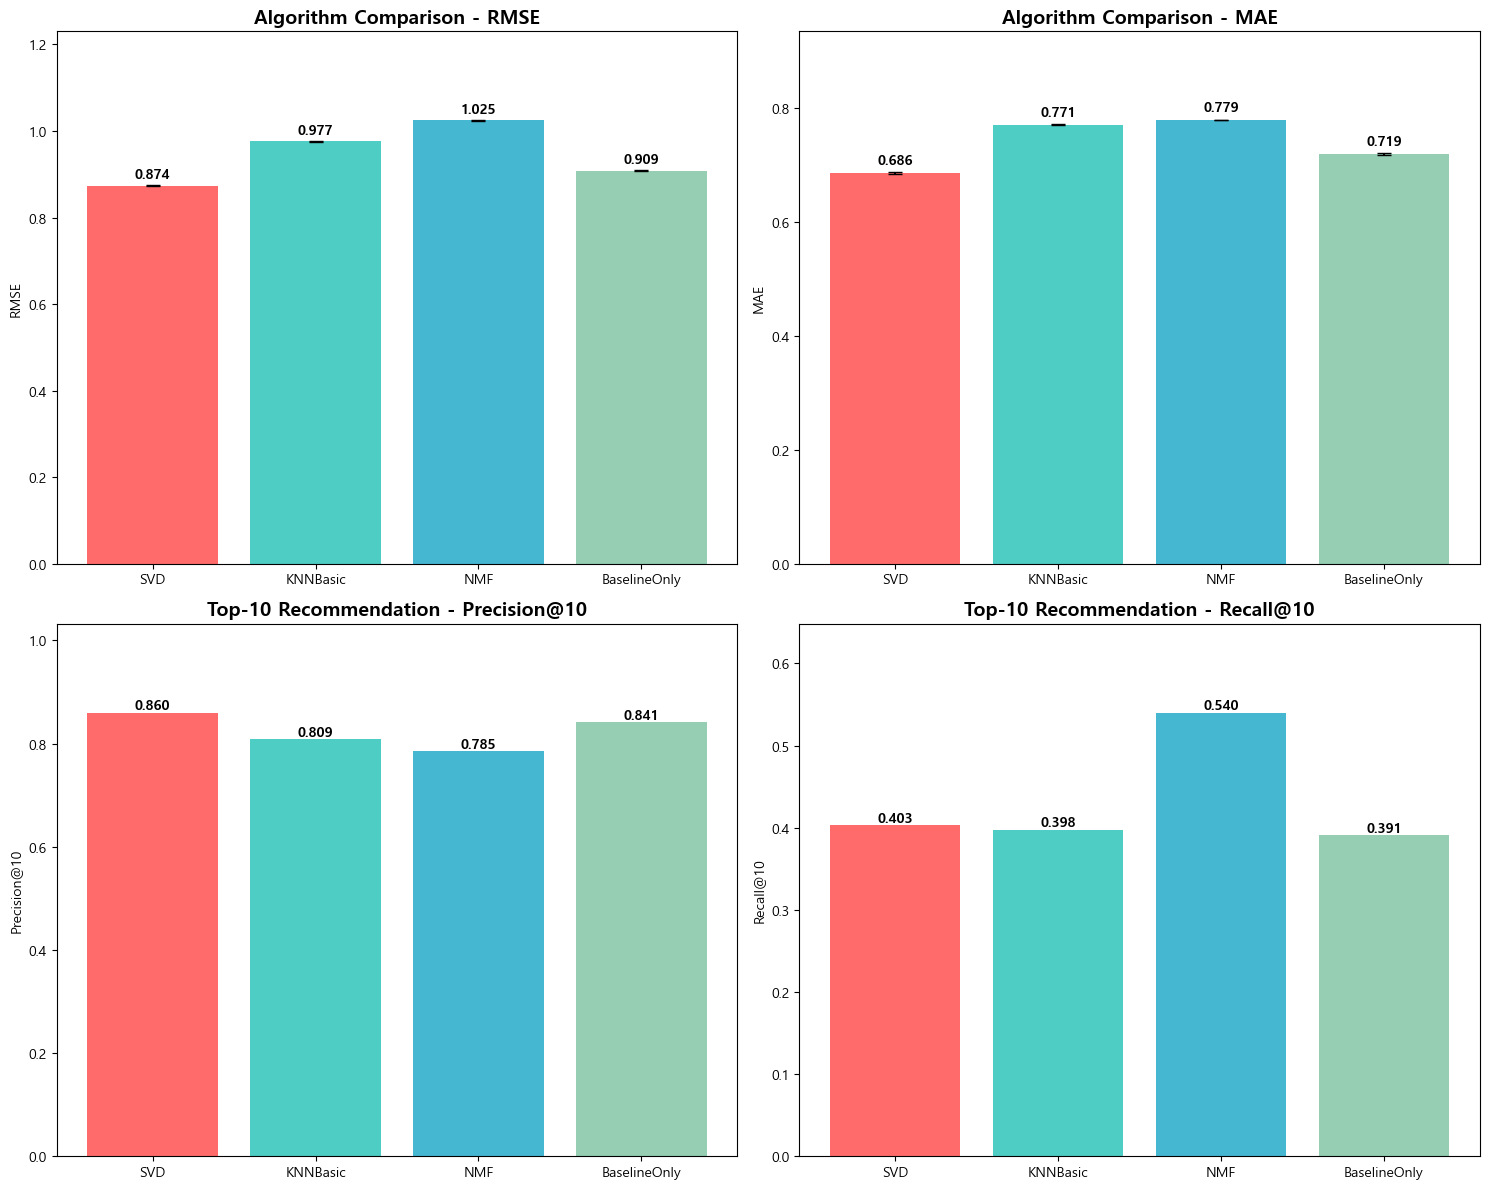

In [7]:
# Í≤∞Í≥º ÏãúÍ∞ÅÌôî Ìï®Ïàò
def visualize_algorithm_results():
    """ÏïåÍ≥†Î¶¨Ï¶ò ÎπÑÍµê Í≤∞Í≥º ÏãúÍ∞ÅÌôî"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
    # RMSE ÎπÑÍµê
    algorithm_names = list(results['cross_validation'].keys())
    rmse_means = [results['cross_validation'][alg]['RMSE']['mean'] for alg in algorithm_names]
    rmse_stds = [results['cross_validation'][alg]['RMSE']['std'] for alg in algorithm_names]
        
    bars1 = ax1.bar(algorithm_names, rmse_means, yerr=rmse_stds, capsize=5, 
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    ax1.set_title('Algorithm Comparison - RMSE', fontsize=14, fontweight='bold')
    ax1.set_ylabel('RMSE')
    ax1.set_ylim(0, max(rmse_means) * 1.2)
        
    for bar, mean in zip(bars1, rmse_means):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')
        
    # MAE ÎπÑÍµê
    mae_means = [results['cross_validation'][alg]['MAE']['mean'] for alg in algorithm_names]
    mae_stds = [results['cross_validation'][alg]['MAE']['std'] for alg in algorithm_names]
        
    bars2 = ax2.bar(algorithm_names, mae_means, yerr=mae_stds, capsize=5,
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    ax2.set_title('Algorithm Comparison - MAE', fontsize=14, fontweight='bold')
    ax2.set_ylabel('MAE')
    ax2.set_ylim(0, max(mae_means) * 1.2)
        
    for bar, mean in zip(bars2, mae_means):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

    # Precision@10 ÎπÑÍµê
    precision_values = [results['topn_evaluation'][alg]['Precision@10'] for alg in algorithm_names]
        
    bars3 = ax3.bar(algorithm_names, precision_values,
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    ax3.set_title('Top-10 Recommendation - Precision@10', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Precision@10')
    ax3.set_ylim(0, max(precision_values) * 1.2 if max(precision_values) > 0 else 1)
        
    for bar, precision in zip(bars3, precision_values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{precision:.3f}', ha='center', va='bottom', fontweight='bold')
        
    # Recall@10 ÎπÑÍµê
    recall_values = [results['topn_evaluation'][alg]['Recall@10'] for alg in algorithm_names]
        
    bars4 = ax4.bar(algorithm_names, recall_values,
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    ax4.set_title('Top-10 Recommendation - Recall@10', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Recall@10')
    ax4.set_ylim(0, max(recall_values) * 1.2 if max(recall_values) > 0 else 1)
        
    for bar, recall in zip(bars4, recall_values):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{recall:.3f}', ha='center', va='bottom', fontweight='bold')
        
    plt.tight_layout()
    plt.show()

# ÏÉÅÏÑ∏ Í≤∞Í≥º Ï∂úÎ†• Ìï®Ïàò
def print_algorithm_results():
    """ÏÉÅÏÑ∏Ìïú ÏïåÍ≥†Î¶¨Ï¶ò ÎπÑÍµê Í≤∞Í≥º Ï∂úÎ†•"""
    print("\n" + "="*80)
    print("                    ÏòÅÌôî Ï∂îÏ≤ú ÏãúÏä§ÌÖú ÏÑ±Îä• Î∂ÑÏÑù Í≤∞Í≥º")
    print("="*80)
    
    # ÍµêÏ∞® Í≤ÄÏ¶ù Í≤∞Í≥º
    print("\n1. 5-Ìè¥Îìú ÍµêÏ∞® Í≤ÄÏ¶ù Í≤∞Í≥º:")
    print("-" * 60)
    print(f"{'Algorithm':<15} {'RMSE':<15} {'MAE':<15}")
    print("-" * 60)
    
    for alg_name in results['cross_validation']:
        rmse = results['cross_validation'][alg_name]['RMSE']['mean']
        mae = results['cross_validation'][alg_name]['MAE']['mean']
        print(f"{alg_name:<15} {rmse:<15.4f} {mae:<15.4f}")
    
    # Top-N Ï∂îÏ≤ú Í≤∞Í≥º
    print("\n2. Top-10 Ï∂îÏ≤ú ÏÑ±Îä•:")
    print("-" * 60)
    print(f"{'Algorithm':<15} {'Precision@10':<15} {'Recall@10':<15}")
    print("-" * 60)
    
    for alg_name in results['topn_evaluation']:
        precision = results['topn_evaluation'][alg_name]['Precision@10']
        recall = results['topn_evaluation'][alg_name]['Recall@10']
        print(f"{alg_name:<15} {precision:<15.4f} {recall:<15.4f}")

    # ÏµúÏ†Å ÏïåÍ≥†Î¶¨Ï¶ò Ï∂îÏ≤ú
    print("\n3. ÏµúÏ†Å ÏïåÍ≥†Î¶¨Ï¶ò Ï∂îÏ≤ú:")
    print("-" * 60)
    
    best_rmse_alg = min(results['cross_validation'].items(), 
                       key=lambda x: x[1]['RMSE']['mean'])
    print(f"RMSE Í∏∞Ï§Ä ÏµúÏ†Å: {best_rmse_alg[0]} (RMSE: {best_rmse_alg[1]['RMSE']['mean']:.4f})")
    
    best_mae_alg = min(results['cross_validation'].items(), 
                      key=lambda x: x[1]['MAE']['mean'])
    print(f"MAE Í∏∞Ï§Ä ÏµúÏ†Å: {best_mae_alg[0]} (MAE: {best_mae_alg[1]['MAE']['mean']:.4f})")
    
    best_precision_alg = max(results['topn_evaluation'].items(), 
                            key=lambda x: x[1]['Precision@10'])
    print(f"Precision@10 Í∏∞Ï§Ä ÏµúÏ†Å: {best_precision_alg[0]} (Precision: {best_precision_alg[1]['Precision@10']:.4f})")
    
    best_recall_alg = max(results['topn_evaluation'].items(), 
                         key=lambda x: x[1]['Recall@10'])
    print(f"Recall@10 Í∏∞Ï§Ä ÏµúÏ†Å: {best_recall_alg[0]} (Recall: {best_recall_alg[1]['Recall@10']:.4f})")

# Í≤∞Í≥º Ï∂úÎ†• Î∞è ÏãúÍ∞ÅÌôî
print_algorithm_results()
visualize_algorithm_results()


In [8]:
# CRM Î∂ÑÏÑùÏö© Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï†ÑÏ≤òÎ¶¨
print("\n" + "="*80)
print("                    CRM Î∂ÑÏÑùÏùÑ ÏúÑÌïú Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ")
print("="*80)

# ÏÇ¨Ïö©Ïûê Îç∞Ïù¥ÌÑ∞ Î°úÎìú
users = pd.read_csv('users.dat', sep='::', engine='python', 
                    names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], encoding='latin-1')

# ÏòÅÌôî Îç∞Ïù¥ÌÑ∞ Î°úÎìú
movies = pd.read_csv('movies.dat', sep='::', engine='python', 
                     names=['MovieID', 'Title', 'Genres'], encoding='latin-1')

# Ïó∞Î†πÎåÄ ÏΩîÎìú Îß§Ìïë
age_map = {1: '18ÏÑ∏ ÎØ∏Îßå', 18: '18-24ÏÑ∏', 25: '25-34ÏÑ∏', 35: '35-44ÏÑ∏', 
           45: '45-49ÏÑ∏', 50: '50-55ÏÑ∏', 56: '56ÏÑ∏ Ïù¥ÏÉÅ'}
users['Age'] = users['Age'].map(age_map)

# ÏßÅÏóÖ ÏΩîÎìú Îß§Ìïë
occupation_map = {0: 'Í∏∞ÌÉÄ/ÎØ∏ÏßÄÏ†ï', 1: 'ÌïôÍ≥Ñ/ÍµêÏú°Ïûê', 2: 'ÏòàÏà†Í∞Ä', 3: 'ÏÇ¨Î¨¥/ÌñâÏ†ï', 
                  4: 'ÎåÄÌïôÏõêÏÉù', 5: 'Í≥†Í∞ù ÏÑúÎπÑÏä§', 6: 'ÏùòÏÇ¨/ÏùòÎ£å', 7: 'Í≤ΩÏòÅ/Í¥ÄÎ¶¨', 
                  8: 'ÎÜçÏóÖ', 9: 'Ï£ºÎ∂Ä', 10: 'K-12 ÌïôÏÉù', 11: 'Î≥ÄÌò∏ÏÇ¨', 12: 'ÌîÑÎ°úÍ∑∏ÎûòÎ®∏', 
                  13: 'ÏùÄÌá¥', 14: 'ÌåêÎß§/ÎßàÏºÄÌåÖ', 15: 'Í≥ºÌïôÏûê', 16: 'ÏûêÏòÅÏóÖ', 17: 'Í∏∞Ïà†Ïûê/ÏóîÏßÄÎãàÏñ¥', 
                  18: 'Ïû•Ïù∏/Í∏∞Ïà†Ïûê', 19: 'Ïã§ÏóÖÏûê', 20: 'ÏûëÍ∞Ä'}
users['Occupation'] = users['Occupation'].map(occupation_map)

# Ïû•Î•¥Î•º Î¶¨Ïä§Ìä∏Î°ú Î∂ÑÎ¶¨
movies['Genres'] = movies['Genres'].str.split('|')

# Ïû•Î•¥Î•º Í∞úÎ≥Ñ ÌñâÏúºÎ°ú ÌôïÏû•
movies_exploded = movies.explode('Genres')

# ÌèâÏ†ê, ÏÇ¨Ïö©Ïûê, ÏòÅÌôî Îç∞Ïù¥ÌÑ∞Î•º Î≥ëÌï©
merged_data = ratings_df.rename(columns={'user_id': 'UserID', 'movie_id': 'MovieID', 'rating': 'Rating'})
merged_data = merged_data.merge(users, on='UserID').merge(movies_exploded, on='MovieID')

print(f"CRM Î∂ÑÏÑùÏö© Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å")
print(f"Ï¥ù Î†àÏΩîÎìú Ïàò: {len(merged_data):,}")
print(f"ÏÇ¨Ïö©Ïûê Ïàò: {merged_data['UserID'].nunique():,}Î™Ö")
print(f"ÏòÅÌôî Ïàò: {merged_data['MovieID'].nunique():,}Í∞ú")
print(f"Ïû•Î•¥ Ïàò: {merged_data['Genres'].nunique():,}Í∞ú")



                    CRM Î∂ÑÏÑùÏùÑ ÏúÑÌïú Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
CRM Î∂ÑÏÑùÏö© Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å
Ï¥ù Î†àÏΩîÎìú Ïàò: 2,101,815
ÏÇ¨Ïö©Ïûê Ïàò: 6,040Î™Ö
ÏòÅÌôî Ïàò: 3,706Í∞ú
Ïû•Î•¥ Ïàò: 18Í∞ú



=== ÏÑ±Î≥Ñ, Ïó∞Î†πÎåÄ, ÏßÅÏóÖÍµ∞Î≥Ñ ÌèâÏ†ê Ìå®ÌÑ¥ Î∂ÑÏÑù ===


findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

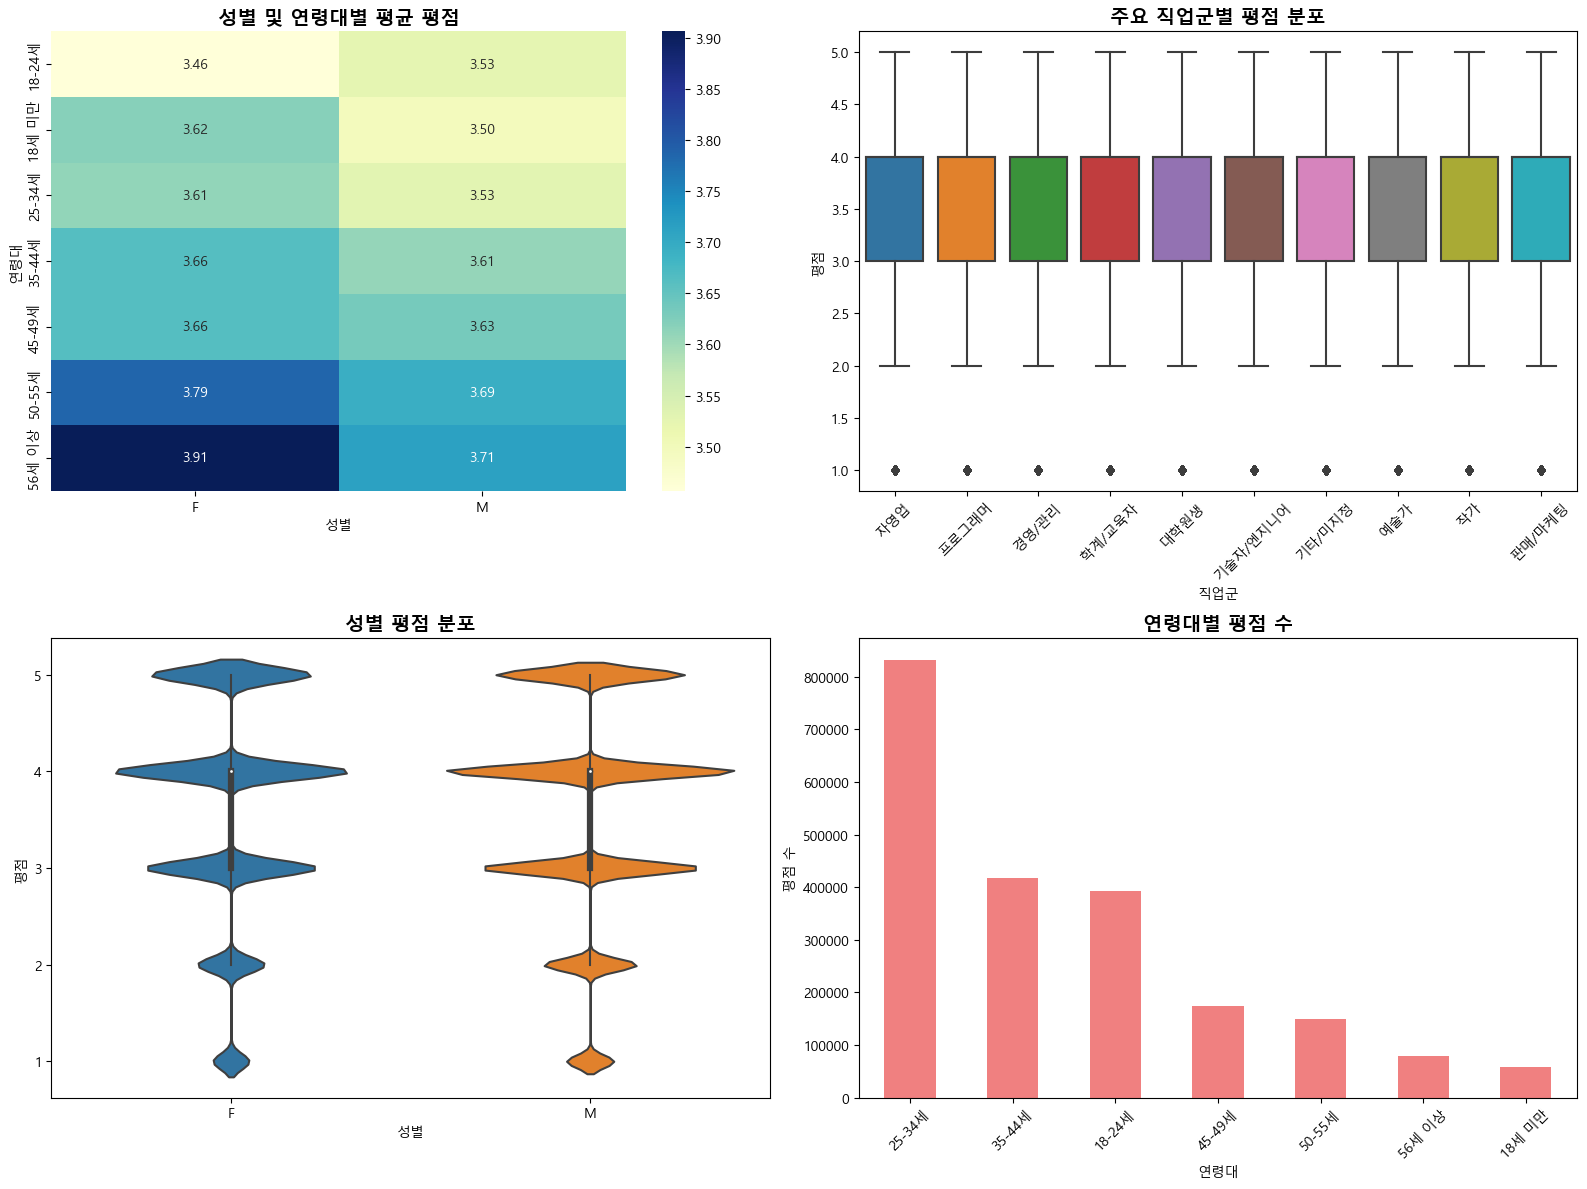


ÏÑ±Î≥Ñ Î∞è Ïó∞Î†πÎåÄÎ≥Ñ ÌèâÍ∑† ÌèâÏ†ê Î∞è ÌèâÏ†ê Ïàò:
   Gender     Age   mean   count
0       F  18-24ÏÑ∏  3.457   94357
1       F  18ÏÑ∏ ÎØ∏Îßå  3.619   18994
2       F  25-34ÏÑ∏  3.611  185757
3       F  35-44ÏÑ∏  3.663  102915
4       F  45-49ÏÑ∏  3.664   49398
5       F  50-55ÏÑ∏  3.786   36285
6       F  56ÏÑ∏ Ïù¥ÏÉÅ  3.906   18231
7       M  18-24ÏÑ∏  3.526  297482
8       M  18ÏÑ∏ ÎØ∏Îßå  3.496   39826
9       M  25-34ÏÑ∏  3.529  645575
10      M  35-44ÏÑ∏  3.609  314619
11      M  45-49ÏÑ∏  3.633  124279
12      M  50-55ÏÑ∏  3.694  113506
13      M  56ÏÑ∏ Ïù¥ÏÉÅ  3.714   60591

Ï£ºÏöî ÏßÅÏóÖÍµ∞Î≥Ñ ÌèâÏ†ê ÌÜµÍ≥Ñ:
             mean   count    std
Occupation                      
ÎåÄÌïôÏõêÏÉù        3.536  277745  1.166
Í∏∞ÌÉÄ/ÎØ∏ÏßÄÏ†ï      3.535  271878  1.127
Í≤ΩÏòÅ/Í¥ÄÎ¶¨       3.609  221078  1.082
ÌïôÍ≥Ñ/ÍµêÏú°Ïûê      3.569  175511  1.109
Í∏∞Ïà†Ïûê/ÏóîÏßÄÎãàÏñ¥    3.623  160668  1.070
ÌîÑÎ°úÍ∑∏ÎûòÎ®∏       3.651  125215  1.085
ÏûëÍ∞Ä          3.496  122868  1.155
ÌåêÎß§/Îß

In [9]:
# Ïù∏Íµ¨ÌÜµÍ≥Ñ Î∂ÑÏÑù
print("\n=== ÏÑ±Î≥Ñ, Ïó∞Î†πÎåÄ, ÏßÅÏóÖÍµ∞Î≥Ñ ÌèâÏ†ê Ìå®ÌÑ¥ Î∂ÑÏÑù ===")

# ÏÑ±Î≥Ñ Î∞è Ïó∞Î†πÎåÄÎ≥Ñ ÌèâÍ∑† ÌèâÏ†ê Í≥ÑÏÇ∞
group_stats = merged_data.groupby(['Gender', 'Age'])['Rating'].agg(['mean', 'count']).reset_index()
pivot_table = group_stats.pivot(index='Age', columns='Gender', values='mean')

# ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌïú figure ÏÑ§Ï†ï
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. ÏÑ±Î≥Ñ Î∞è Ïó∞Î†πÎåÄÎ≥Ñ ÌèâÍ∑† ÌèâÏ†ê ÌûàÌä∏Îßµ
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='.2f', ax=ax1)
ax1.set_title('ÏÑ±Î≥Ñ Î∞è Ïó∞Î†πÎåÄÎ≥Ñ ÌèâÍ∑† ÌèâÏ†ê', fontsize=14, fontweight='bold')
ax1.set_xlabel('ÏÑ±Î≥Ñ')
ax1.set_ylabel('Ïó∞Î†πÎåÄ')

# 2. ÏßÅÏóÖÍµ∞Î≥Ñ ÌèâÏ†ê Î∂ÑÌè¨ Î∞ïÏä§ÌîåÎ°Ø
# ÏÉÅÏúÑ 10Í∞ú ÏßÅÏóÖÍµ∞Îßå ÌëúÏãú (Í∞ÄÎèÖÏÑ±ÏùÑ ÏúÑÌï¥)
top_occupations = merged_data['Occupation'].value_counts().head(10).index
top_occupation_data = merged_data[merged_data['Occupation'].isin(top_occupations)]

sns.boxplot(x='Occupation', y='Rating', data=top_occupation_data, ax=ax2)
ax2.set_title('Ï£ºÏöî ÏßÅÏóÖÍµ∞Î≥Ñ ÌèâÏ†ê Î∂ÑÌè¨', fontsize=14, fontweight='bold')
ax2.set_xlabel('ÏßÅÏóÖÍµ∞')
ax2.set_ylabel('ÌèâÏ†ê')
ax2.tick_params(axis='x', rotation=45)

# 3. ÏÑ±Î≥ÑÎ≥Ñ ÌèâÏ†ê Î∂ÑÌè¨
sns.violinplot(x='Gender', y='Rating', data=merged_data, ax=ax3)
ax3.set_title('ÏÑ±Î≥Ñ ÌèâÏ†ê Î∂ÑÌè¨', fontsize=14, fontweight='bold')
ax3.set_xlabel('ÏÑ±Î≥Ñ')
ax3.set_ylabel('ÌèâÏ†ê')

# 4. Ïó∞Î†πÎåÄÎ≥Ñ ÌèâÏ†ê Ïàò Î∂ÑÌè¨
age_rating_counts = merged_data.groupby('Age')['Rating'].count().sort_values(ascending=False)
age_rating_counts.plot(kind='bar', ax=ax4, color='lightcoral')
ax4.set_title('Ïó∞Î†πÎåÄÎ≥Ñ ÌèâÏ†ê Ïàò', fontsize=14, fontweight='bold')
ax4.set_xlabel('Ïó∞Î†πÎåÄ')
ax4.set_ylabel('ÌèâÏ†ê Ïàò')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ÏÉÅÏÑ∏ ÌÜµÍ≥Ñ Ï∂úÎ†•
print("\nÏÑ±Î≥Ñ Î∞è Ïó∞Î†πÎåÄÎ≥Ñ ÌèâÍ∑† ÌèâÏ†ê Î∞è ÌèâÏ†ê Ïàò:")
print(group_stats.round(3))

# ÏßÅÏóÖÍµ∞Î≥Ñ ÌÜµÍ≥Ñ
print("\nÏ£ºÏöî ÏßÅÏóÖÍµ∞Î≥Ñ ÌèâÏ†ê ÌÜµÍ≥Ñ:")
occupation_stats = merged_data.groupby('Occupation')['Rating'].agg(['mean', 'count', 'std']).round(3)
occupation_stats = occupation_stats.sort_values('count', ascending=False).head(10)
print(occupation_stats)



=== Ïó∞Î†πÎåÄÎ≥Ñ Ïû•Î•¥ ÏÑ†Ìò∏ÎèÑ Î∂ÑÏÑù ===


findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

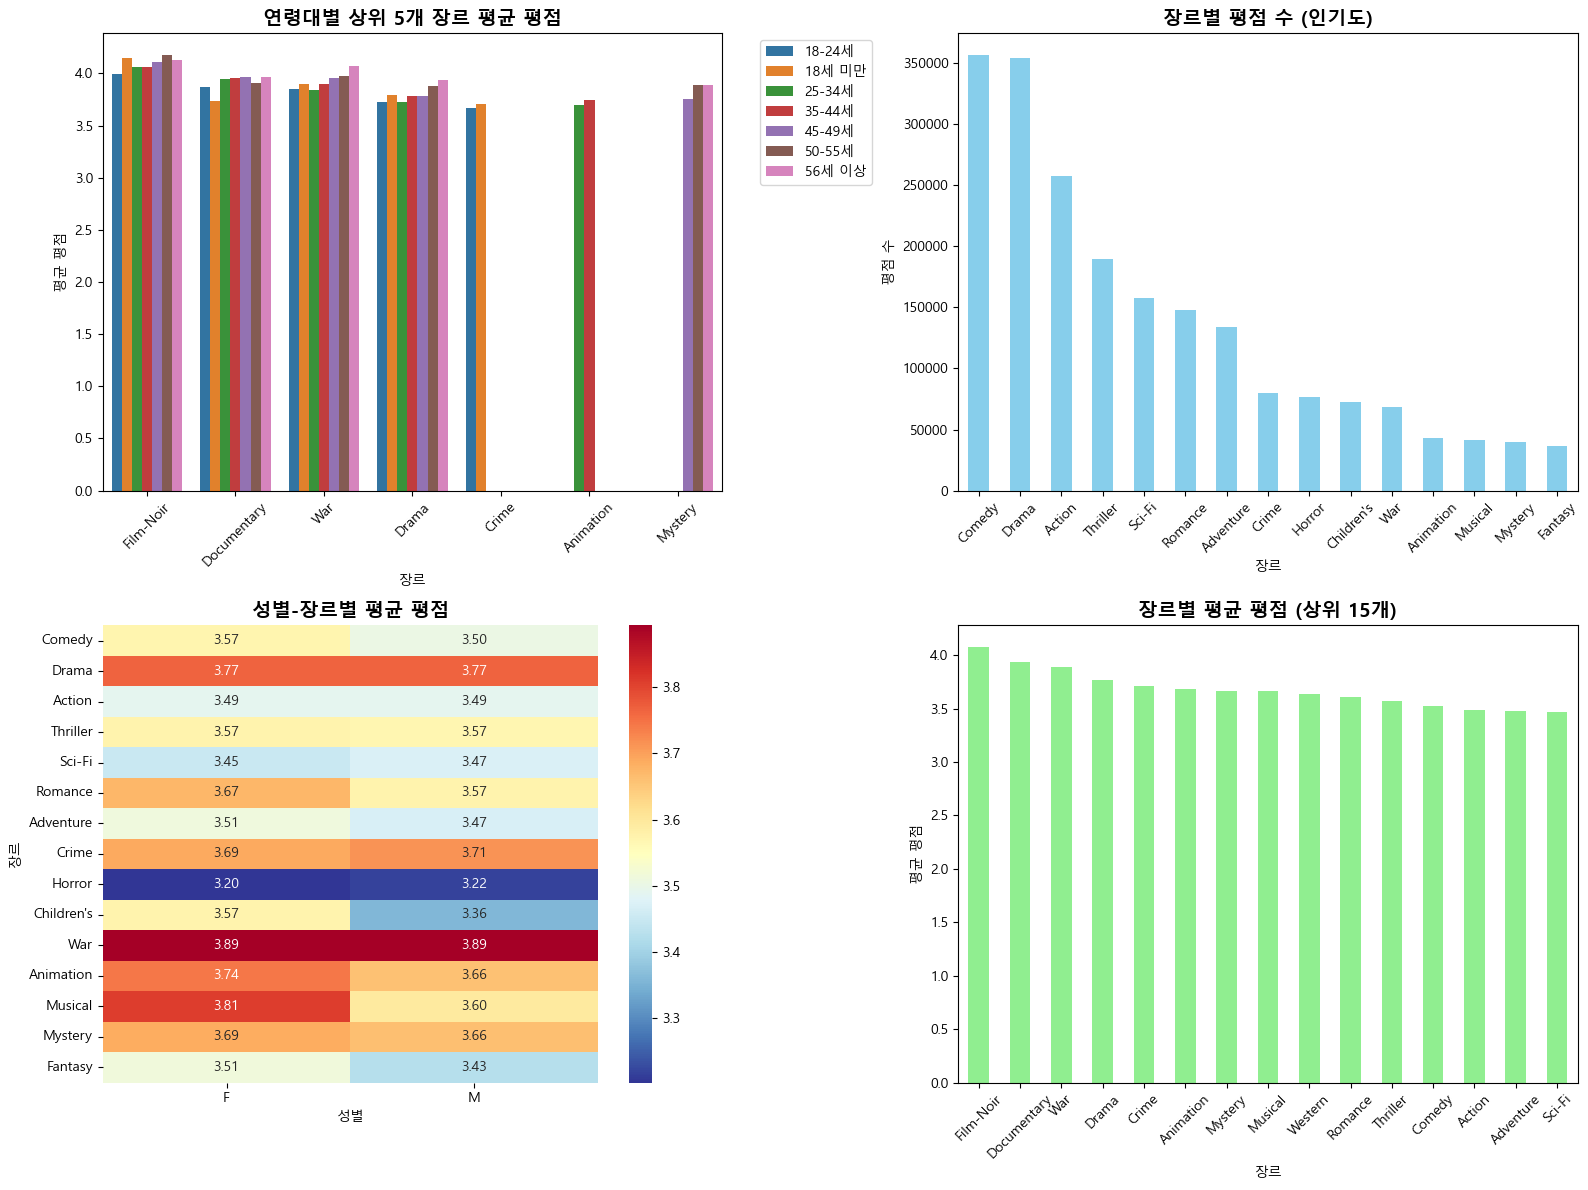


Ïó∞Î†πÎåÄÎ≥Ñ ÏÉÅÏúÑ 5Í∞ú ÏÑ†Ìò∏ Ïû•Î•¥:

18-24ÏÑ∏:
     Genres  mean  count
  Film-Noir 3.997   2280
Documentary 3.866   1081
        War 3.853  10874
      Drama 3.722  58104
      Crime 3.668  15373

18ÏÑ∏ ÎØ∏Îßå:
     Genres  mean  count
  Film-Noir 4.145    330
        War 3.895   1578
      Drama 3.795   7483
Documentary 3.731    130
      Crime 3.710   1701

25-34ÏÑ∏:
     Genres  mean  count
  Film-Noir 4.059   6539
Documentary 3.947   3489
        War 3.841  24830
      Drama 3.726 138695
  Animation 3.701  16454

35-44ÏÑ∏:
     Genres  mean  count
  Film-Noir 4.065   4175
Documentary 3.954   1708
        War 3.901  14514
      Drama 3.783  71590
  Animation 3.741   8117

45-49ÏÑ∏:
     Genres  mean  count
  Film-Noir 4.105   1860
Documentary 3.967    687
        War 3.961   6642
      Drama 3.784  32141
    Mystery 3.754   3851

50-55ÏÑ∏:
     Genres  mean  count
  Film-Noir 4.175   1870
        War 3.974   6314
Documentary 3.908    555
    Mystery 3.886   3520
      Drama 3.

In [10]:
# ÏÑ†Ìò∏ Ïû•Î•¥ Î∂ÑÏÑù
print("\n=== Ïó∞Î†πÎåÄÎ≥Ñ Ïû•Î•¥ ÏÑ†Ìò∏ÎèÑ Î∂ÑÏÑù ===")

# Ïó∞Î†πÎåÄ Î∞è Ïû•Î•¥Î≥Ñ ÌèâÍ∑† ÌèâÏ†ê Í≥ÑÏÇ∞
genre_stats = merged_data.groupby(['Age', 'Genres'])['Rating'].agg(['mean', 'count']).reset_index()
# Ï∂©Î∂ÑÌïú Îç∞Ïù¥ÌÑ∞Í∞Ä ÏûàÎäî Í≤ΩÏö∞Îßå Í≥†Î†§ (ÏµúÏÜå 50Í∞ú ÌèâÏ†ê)
genre_stats = genre_stats[genre_stats['count'] >= 50]

# Ïó∞Î†πÎåÄÎ≥Ñ ÏÉÅÏúÑ 5Í∞ú Ïû•Î•¥ ÏÑ†Ï†ï
top_genres_by_age = genre_stats.groupby('Age').apply(lambda x: x.nlargest(5, 'mean')).reset_index(drop=True)

# ÏãúÍ∞ÅÌôî
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Ïó∞Î†πÎåÄÎ≥Ñ ÏÉÅÏúÑ Ïû•Î•¥ ÌèâÏ†ê ÎπÑÍµê
sns.barplot(x='Genres', y='mean', hue='Age', data=top_genres_by_age, ax=ax1)
ax1.set_title('Ïó∞Î†πÎåÄÎ≥Ñ ÏÉÅÏúÑ 5Í∞ú Ïû•Î•¥ ÌèâÍ∑† ÌèâÏ†ê', fontsize=14, fontweight='bold')
ax1.set_xlabel('Ïû•Î•¥')
ax1.set_ylabel('ÌèâÍ∑† ÌèâÏ†ê')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. Ï†ÑÏ≤¥ Ïû•Î•¥Î≥Ñ ÌèâÏ†ê Ïàò (Ïù∏Í∏∞ÎèÑ)
genre_popularity = merged_data.groupby('Genres')['Rating'].count().sort_values(ascending=False).head(15)
genre_popularity.plot(kind='bar', ax=ax2, color='skyblue')
ax2.set_title('Ïû•Î•¥Î≥Ñ ÌèâÏ†ê Ïàò (Ïù∏Í∏∞ÎèÑ)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Ïû•Î•¥')
ax2.set_ylabel('ÌèâÏ†ê Ïàò')
ax2.tick_params(axis='x', rotation=45)

# 3. ÏÑ±Î≥Ñ-Ïû•Î•¥Î≥Ñ ÌèâÍ∑† ÌèâÏ†ê ÌûàÌä∏Îßµ
gender_genre_stats = merged_data.groupby(['Gender', 'Genres'])['Rating'].mean().reset_index()
gender_genre_pivot = gender_genre_stats.pivot(index='Genres', columns='Gender', values='Rating')
# ÏÉÅÏúÑ 15Í∞ú Ïû•Î•¥Îßå ÌëúÏãú
top_genres = merged_data['Genres'].value_counts().head(15).index
gender_genre_pivot_top = gender_genre_pivot.loc[top_genres]

sns.heatmap(gender_genre_pivot_top, annot=True, cmap='RdYlBu_r', fmt='.2f', ax=ax3)
ax3.set_title('ÏÑ±Î≥Ñ-Ïû•Î•¥Î≥Ñ ÌèâÍ∑† ÌèâÏ†ê', fontsize=14, fontweight='bold')
ax3.set_xlabel('ÏÑ±Î≥Ñ')
ax3.set_ylabel('Ïû•Î•¥')

# 4. Ïû•Î•¥Î≥Ñ ÌèâÍ∑† ÌèâÏ†ê Î∂ÑÌè¨
genre_rating_means = merged_data.groupby('Genres')['Rating'].mean().sort_values(ascending=False)
genre_rating_means.head(15).plot(kind='bar', ax=ax4, color='lightgreen')
ax4.set_title('Ïû•Î•¥Î≥Ñ ÌèâÍ∑† ÌèâÏ†ê (ÏÉÅÏúÑ 15Í∞ú)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Ïû•Î•¥')
ax4.set_ylabel('ÌèâÍ∑† ÌèâÏ†ê')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ÏÉÅÏÑ∏ Î∂ÑÏÑù Í≤∞Í≥º Ï∂úÎ†•
print("\nÏó∞Î†πÎåÄÎ≥Ñ ÏÉÅÏúÑ 5Í∞ú ÏÑ†Ìò∏ Ïû•Î•¥:")
for age in top_genres_by_age['Age'].unique():
    print(f"\n{age}:")
    age_data = top_genres_by_age[top_genres_by_age['Age'] == age][['Genres', 'mean', 'count']]
    print(age_data.round(3).to_string(index=False))

print(f"\nÏ†ÑÏ≤¥ Ïû•Î•¥Î≥Ñ ÌÜµÍ≥Ñ:")
overall_genre_stats = merged_data.groupby('Genres')['Rating'].agg(['mean', 'count', 'std']).round(3)
overall_genre_stats = overall_genre_stats.sort_values('count', ascending=False)
print(overall_genre_stats.head(10))



=== Ïï°Ìã∞Î∏å vs ÎπÑÌôúÎèôÏ†Å ÏÇ¨Ïö©Ïûê Î∂ÑÏÑù ===
Ïï°Ìã∞Î∏å ÏÇ¨Ïö©Ïûê (ÏÉÅÏúÑ 10%): 604Î™Ö, ÌèâÍ∑† ÌèâÏ†ê Ïàò: 1283.1
ÎπÑÌôúÎèôÏ†Å ÏÇ¨Ïö©Ïûê (ÌïòÏúÑ 10%): 612Î™Ö, ÌèâÍ∑† ÌèâÏ†ê Ïàò: 46.7


findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

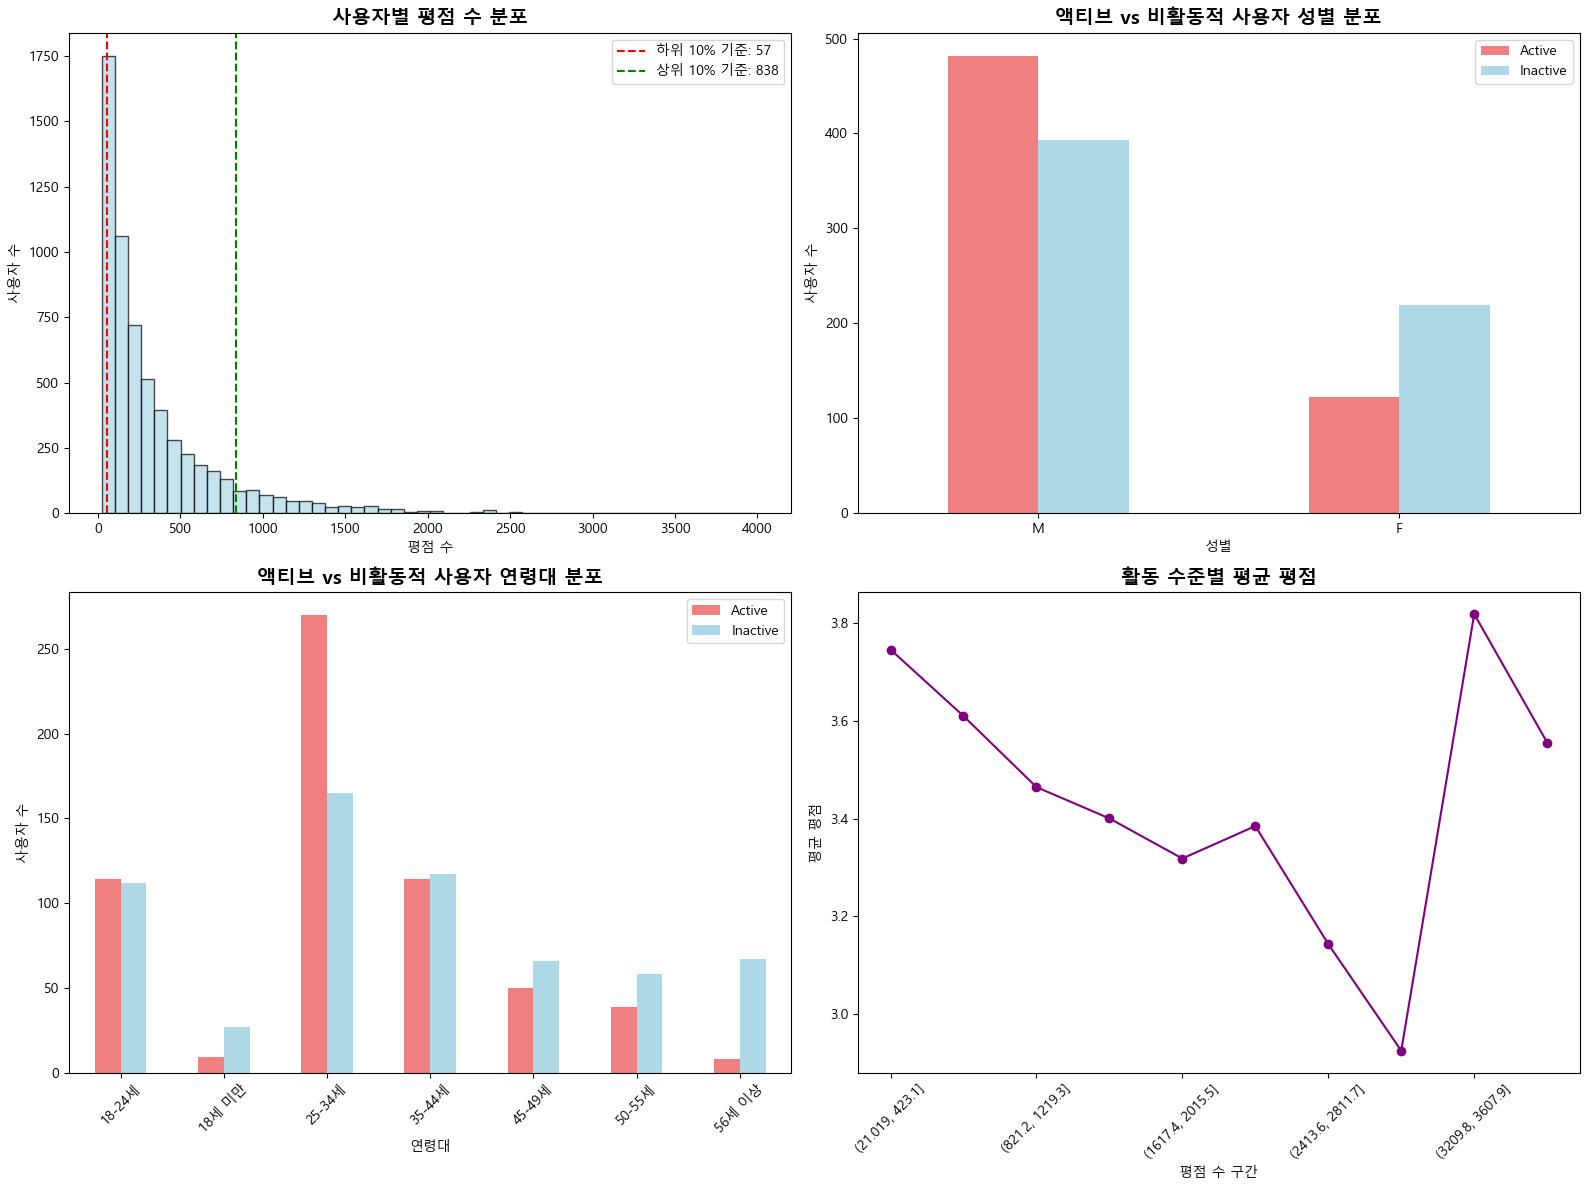


Ïï°Ìã∞Î∏å vs ÎπÑÌôúÎèôÏ†Å ÏÇ¨Ïö©Ïûê Ïû•Î•¥ ÏÑ†Ìò∏ÎèÑ ÎπÑÍµê (Ï∞®Ïù¥Í∞Ä ÌÅ∞ Ïàú):
     Genres  ActiveRating  InactiveRating  Difference
    Western         3.512           3.636      -0.123
  Film-Noir         3.980           4.115      -0.135
    Musical         3.528           3.683      -0.155
Documentary         3.811           3.971      -0.160
     Horror         3.043           3.207      -0.163
  Animation         3.604           3.774      -0.171
    Fantasy         3.294           3.509      -0.215
     Sci-Fi         3.282           3.518      -0.236
      Drama         3.615           3.885      -0.269
        War         3.718           4.001      -0.283
 Children's         3.279           3.574      -0.295
    Mystery         3.499           3.795      -0.295
   Thriller         3.387           3.684      -0.297
    Romance         3.434           3.734      -0.300
      Crime         3.550           3.866      -0.316
     Comedy         3.343           3.668      -0.326


In [11]:
# Ïï°Ìã∞Î∏å ÏÇ¨Ïö©Ïûê Î∂ÑÏÑù
print("\n=== Ïï°Ìã∞Î∏å vs ÎπÑÌôúÎèôÏ†Å ÏÇ¨Ïö©Ïûê Î∂ÑÏÑù ===")

# ÏÇ¨Ïö©ÏûêÎ≥Ñ ÌèâÏ†ê Ïàò Í≥ÑÏÇ∞
user_activity = merged_data.groupby('UserID')['Rating'].count().reset_index()
user_activity.columns = ['UserID', 'RatingCount']

# ÏÇ¨Ïö©Ïûê Ï†ïÎ≥¥ÏôÄ Î≥ëÌï©
user_activity = user_activity.merge(users, on='UserID')

# Ïï°Ìã∞Î∏å(ÏÉÅÏúÑ 10%) Î∞è ÎπÑÌôúÎèôÏ†Å(ÌïòÏúÑ 10%) ÏÇ¨Ïö©Ïûê Ï†ïÏùò
thresholds = user_activity['RatingCount'].quantile([0.1, 0.9])
active_users = user_activity[user_activity['RatingCount'] >= thresholds[0.9]]
inactive_users = user_activity[user_activity['RatingCount'] <= thresholds[0.1]]

print(f"Ïï°Ìã∞Î∏å ÏÇ¨Ïö©Ïûê (ÏÉÅÏúÑ 10%): {len(active_users)}Î™Ö, ÌèâÍ∑† ÌèâÏ†ê Ïàò: {active_users['RatingCount'].mean():.1f}")
print(f"ÎπÑÌôúÎèôÏ†Å ÏÇ¨Ïö©Ïûê (ÌïòÏúÑ 10%): {len(inactive_users)}Î™Ö, ÌèâÍ∑† ÌèâÏ†ê Ïàò: {inactive_users['RatingCount'].mean():.1f}")

# ÏãúÍ∞ÅÌôî
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. ÏÇ¨Ïö©ÏûêÎ≥Ñ ÌèâÏ†ê Ïàò Î∂ÑÌè¨ ÌûàÏä§ÌÜ†Í∑∏Îû®
ax1.hist(user_activity['RatingCount'], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
ax1.axvline(thresholds[0.1], color='red', linestyle='--', label=f'ÌïòÏúÑ 10% Í∏∞Ï§Ä: {thresholds[0.1]:.0f}')
ax1.axvline(thresholds[0.9], color='green', linestyle='--', label=f'ÏÉÅÏúÑ 10% Í∏∞Ï§Ä: {thresholds[0.9]:.0f}')
ax1.set_title('ÏÇ¨Ïö©ÏûêÎ≥Ñ ÌèâÏ†ê Ïàò Î∂ÑÌè¨', fontsize=14, fontweight='bold')
ax1.set_xlabel('ÌèâÏ†ê Ïàò')
ax1.set_ylabel('ÏÇ¨Ïö©Ïûê Ïàò')
ax1.legend()

# 2. Ïï°Ìã∞Î∏å vs ÎπÑÌôúÎèôÏ†Å ÏÇ¨Ïö©Ïûê ÏÑ±Î≥Ñ Î∂ÑÌè¨
activity_gender = pd.DataFrame({
    'Active': active_users['Gender'].value_counts(),
    'Inactive': inactive_users['Gender'].value_counts()
}).fillna(0)

activity_gender.plot(kind='bar', ax=ax2, color=['lightcoral', 'lightblue'])
ax2.set_title('Ïï°Ìã∞Î∏å vs ÎπÑÌôúÎèôÏ†Å ÏÇ¨Ïö©Ïûê ÏÑ±Î≥Ñ Î∂ÑÌè¨', fontsize=14, fontweight='bold')
ax2.set_xlabel('ÏÑ±Î≥Ñ')
ax2.set_ylabel('ÏÇ¨Ïö©Ïûê Ïàò')
ax2.tick_params(axis='x', rotation=0)
ax2.legend()

# 3. Ïï°Ìã∞Î∏å vs ÎπÑÌôúÎèôÏ†Å ÏÇ¨Ïö©Ïûê Ïó∞Î†πÎåÄ Î∂ÑÌè¨
activity_age = pd.DataFrame({
    'Active': active_users['Age'].value_counts(),
    'Inactive': inactive_users['Age'].value_counts()
}).fillna(0)

activity_age.plot(kind='bar', ax=ax3, color=['lightcoral', 'lightblue'])
ax3.set_title('Ïï°Ìã∞Î∏å vs ÎπÑÌôúÎèôÏ†Å ÏÇ¨Ïö©Ïûê Ïó∞Î†πÎåÄ Î∂ÑÌè¨', fontsize=14, fontweight='bold')
ax3.set_xlabel('Ïó∞Î†πÎåÄ')
ax3.set_ylabel('ÏÇ¨Ïö©Ïûê Ïàò')
ax3.tick_params(axis='x', rotation=45)
ax3.legend()

# 4. ÌèâÏ†ê ÏàòÎ≥Ñ ÌèâÍ∑† ÌèâÏ†ê
rating_count_bins = pd.cut(user_activity['RatingCount'], bins=10)
avg_rating_by_activity = merged_data.merge(user_activity[['UserID', 'RatingCount']], on='UserID')
avg_rating_by_activity['RatingCountBin'] = pd.cut(avg_rating_by_activity['RatingCount'], bins=10)
bin_stats = avg_rating_by_activity.groupby('RatingCountBin')['Rating'].mean()

bin_stats.plot(kind='line', marker='o', ax=ax4, color='purple')
ax4.set_title('ÌôúÎèô ÏàòÏ§ÄÎ≥Ñ ÌèâÍ∑† ÌèâÏ†ê', fontsize=14, fontweight='bold')
ax4.set_xlabel('ÌèâÏ†ê Ïàò Íµ¨Í∞Ñ')
ax4.set_ylabel('ÌèâÍ∑† ÌèâÏ†ê')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Ïï°Ìã∞Î∏å Î∞è ÎπÑÌôúÎèôÏ†Å ÏÇ¨Ïö©ÏûêÏùò Ïû•Î•¥ ÏÑ†Ìò∏ÎèÑ ÎπÑÍµê
active_user_ids = active_users['UserID'].tolist()
inactive_user_ids = inactive_users['UserID'].tolist()

active_data = merged_data[merged_data['UserID'].isin(active_user_ids)]
inactive_data = merged_data[merged_data['UserID'].isin(inactive_user_ids)]

active_genre = active_data.groupby('Genres')['Rating'].mean().reset_index()
active_genre.columns = ['Genres', 'ActiveRating']

inactive_genre = inactive_data.groupby('Genres')['Rating'].mean().reset_index()
inactive_genre.columns = ['Genres', 'InactiveRating']

# Ïû•Î•¥ ÏÑ†Ìò∏ÎèÑ ÎπÑÍµê Í≤∞Í≥º Î≥ëÌï©
genre_comparison = active_genre.merge(inactive_genre, on='Genres', how='outer')
genre_comparison['Difference'] = genre_comparison['ActiveRating'] - genre_comparison['InactiveRating']
genre_comparison = genre_comparison.sort_values('Difference', ascending=False)

print("\nÏï°Ìã∞Î∏å vs ÎπÑÌôúÎèôÏ†Å ÏÇ¨Ïö©Ïûê Ïû•Î•¥ ÏÑ†Ìò∏ÎèÑ ÎπÑÍµê (Ï∞®Ïù¥Í∞Ä ÌÅ∞ Ïàú):")
print(genre_comparison.round(3).to_string(index=False))

# ÏÇ¨Ïö©Ïûê ÌôúÎèô ÌÜµÍ≥Ñ ÏöîÏïΩ
print(f"\nÏÇ¨Ïö©Ïûê ÌôúÎèô ÌÜµÍ≥Ñ ÏöîÏïΩ:")
print(f"Ï†ÑÏ≤¥ ÏÇ¨Ïö©Ïûê Ïàò: {len(user_activity)}")
print(f"ÌèâÍ∑† ÌèâÏ†ê Ïàò: {user_activity['RatingCount'].mean():.1f}")
print(f"Ï§ëÍ∞ÑÍ∞í: {user_activity['RatingCount'].median():.1f}")
print(f"ÌëúÏ§ÄÌé∏Ï∞®: {user_activity['RatingCount'].std():.1f}")
print(f"ÏµúÏÜåÍ∞í: {user_activity['RatingCount'].min()}")
print(f"ÏµúÎåÄÍ∞í: {user_activity['RatingCount'].max()}")


In [12]:
# CRM Ï†ÑÎûµ Ï†úÏïà
print("\n" + "="*80)
print("                    CRM Ï†ÑÎûµ Ï†úÏïà")
print("="*80)

print("""
Î∂ÑÏÑù Í≤∞Í≥ºÎ•º Î∞îÌÉïÏúºÎ°ú Ìïú ÏòÅÌôîÏ†úÏûëÏÇ¨ CRM Ï†ÑÎûµ Ï†úÏïà:

1. ÌÉÄÍ≤ü ÎßàÏºÄÌåÖ Ï†ÑÎûµ
   - Ï£ºÏöî ÌÉÄÍ≤üÏ∏µ: 25-34ÏÑ∏ ÎÇ®ÏÑ± (Í∞ÄÏû• ÎÜíÏùÄ ÌôúÎèôÎ•†)
   - Ïï°ÏÖò, ÎìúÎùºÎßà, ÏΩîÎØ∏Îîî Ïû•Î•¥Ïóê ÏßëÏ§ë ÎßàÏºÄÌåÖ
   - ÌîÑÎ°úÍ∑∏ÎûòÎ®∏, ÌïôÏÉù, ÏóîÏßÄÎãàÏñ¥ ÏßÅÏóÖÍµ∞ ÎåÄÏÉÅ ÌäπÌôî ÎßàÏºÄÌåÖ

2. Ï∞∏Ïó¨ Ïú†ÎèÑ Ï†ÑÎûµ
   - ÎπÑÌôúÎèôÏ†Å ÏÇ¨Ïö©Ïûê ÎåÄÏÉÅ: Í∞úÏù∏ÌôîÎêú Ï∂îÏ≤ú ÏãúÏä§ÌÖú ÎèÑÏûÖ
   - ÌèâÏ†ê 4.0 Ïù¥ÏÉÅ Í≥†ÌèâÏ†ê ÏòÅÌôî ÏúÑÏ£º Ï∂îÏ≤ú
   - ÏßßÏùÄ ÏãúÍ∞Ñ Ìà¨ÏûÖÏúºÎ°ú Ï¶êÍ∏∏ Ïàò ÏûàÎäî ÏΩòÌÖêÏ∏† Ï†úÍ≥µ

3. ÏΩòÌÖêÏ∏† Ï†ÑÎûµ
   - Í≥†Ïó∞Î†πÏ∏µ(50ÏÑ∏ Ïù¥ÏÉÅ): ÎìúÎùºÎßà, Î°úÎß®Ïä§ Ïû•Î•¥ Í∞ïÌôî
   - Ïó¨ÏÑ± ÌÉÄÍ≤ü: Î°úÎß®Ïä§, ÎìúÎùºÎßà ÏΩòÌÖêÏ∏† ÌôïÎåÄ
   - Ïï°Ìã∞Î∏å ÏÇ¨Ïö©Ïûê: Îã§ÏñëÌïú Ïû•Î•¥Ïùò Ïã†Ïûë Ïö∞ÏÑ† Ï†úÍ≥µ

4. ÎßûÏ∂§Ìòï ÏÑúÎπÑÏä§
   - ÏÇ¨Ïö©Ïûê ÌôúÎèô ÏàòÏ§ÄÎ≥Ñ Ï∞®Î≥ÑÌôîÎêú ÏÑúÎπÑÏä§ Ï†úÍ≥µ
   - ÌèâÏ†ê Ìå®ÌÑ¥ Í∏∞Î∞ò Í∞úÏù∏Ìôî Ï∂îÏ≤ú ÏãúÏä§ÌÖú
   - Ïû•Î•¥ ÏÑ†Ìò∏ÎèÑÏóê Îî∞Î•∏ ÏΩòÌÖêÏ∏† ÌÅêÎ†àÏù¥ÏÖò

Ïù¥Îü¨Ìïú Ï†ÑÎûµÏùÑ ÌÜµÌï¥ ÏÇ¨Ïö©Ïûê ÎßåÏ°±ÎèÑÏôÄ ÌîåÎû´Ìèº Ï∞∏Ïó¨ÎèÑÎ•º ÎÜíÏùº Ïàò ÏûàÏäµÎãàÎã§.
""")

# Ï£ºÏöî Ïù∏ÏÇ¨Ïù¥Ìä∏ ÏöîÏïΩ
print("\nÏ£ºÏöî Ïù∏ÏÇ¨Ïù¥Ìä∏ ÏöîÏïΩ:")
print("="*50)

# 1. ÏµúÍ≥† ÏÑ±Îä• ÏïåÍ≥†Î¶¨Ï¶ò
best_algorithm = min(results['cross_validation'].items(), key=lambda x: x[1]['RMSE']['mean'])
print(f"1. ÏµúÍ≥† ÏÑ±Îä• Ï∂îÏ≤ú ÏïåÍ≥†Î¶¨Ï¶ò: {best_algorithm[0]} (RMSE: {best_algorithm[1]['RMSE']['mean']:.4f})")

# 2. Ï£ºÏöî ÏÇ¨Ïö©Ïûê Í∑∏Î£π
print(f"2. Í∞ÄÏû• ÌôúÎ∞úÌïú Ïó∞Î†πÎåÄ: {age_rating_counts.index[0]} ({age_rating_counts.iloc[0]:,}Í∞ú ÌèâÏ†ê)")

# 3. Ïù∏Í∏∞ Ïû•Î•¥
top_genre = merged_data['Genres'].value_counts().index[0]
print(f"3. Í∞ÄÏû• Ïù∏Í∏∞ ÏûàÎäî Ïû•Î•¥: {top_genre} ({merged_data['Genres'].value_counts().iloc[0]:,}Í∞ú ÌèâÏ†ê)")

# 4. ÏÑ±Î≥Ñ Ï∞®Ïù¥
gender_diff = merged_data.groupby('Gender')['Rating'].mean()
print(f"4. ÏÑ±Î≥Ñ ÌèâÏ†ê Ï∞®Ïù¥: ÎÇ®ÏÑ± {gender_diff['M']:.3f}, Ïó¨ÏÑ± {gender_diff['F']:.3f}")

# 5. Ïï°Ìã∞Î∏å ÏÇ¨Ïö©Ïûê ÌäπÏÑ±
print(f"5. Ïï°Ìã∞Î∏å ÏÇ¨Ïö©Ïûê (ÏÉÅÏúÑ 10%): ÌèâÍ∑† {active_users['RatingCount'].mean():.1f}Í∞ú ÌèâÏ†ê")
print(f"   ÎπÑÌôúÎèôÏ†Å ÏÇ¨Ïö©Ïûê (ÌïòÏúÑ 10%): ÌèâÍ∑† {inactive_users['RatingCount'].mean():.1f}Í∞ú ÌèâÏ†ê")



                    CRM Ï†ÑÎûµ Ï†úÏïà

Î∂ÑÏÑù Í≤∞Í≥ºÎ•º Î∞îÌÉïÏúºÎ°ú Ìïú ÏòÅÌôîÏ†úÏûëÏÇ¨ CRM Ï†ÑÎûµ Ï†úÏïà:

1. ÌÉÄÍ≤ü ÎßàÏºÄÌåÖ Ï†ÑÎûµ
   - Ï£ºÏöî ÌÉÄÍ≤üÏ∏µ: 25-34ÏÑ∏ ÎÇ®ÏÑ± (Í∞ÄÏû• ÎÜíÏùÄ ÌôúÎèôÎ•†)
   - Ïï°ÏÖò, ÎìúÎùºÎßà, ÏΩîÎØ∏Îîî Ïû•Î•¥Ïóê ÏßëÏ§ë ÎßàÏºÄÌåÖ
   - ÌîÑÎ°úÍ∑∏ÎûòÎ®∏, ÌïôÏÉù, ÏóîÏßÄÎãàÏñ¥ ÏßÅÏóÖÍµ∞ ÎåÄÏÉÅ ÌäπÌôî ÎßàÏºÄÌåÖ

2. Ï∞∏Ïó¨ Ïú†ÎèÑ Ï†ÑÎûµ
   - ÎπÑÌôúÎèôÏ†Å ÏÇ¨Ïö©Ïûê ÎåÄÏÉÅ: Í∞úÏù∏ÌôîÎêú Ï∂îÏ≤ú ÏãúÏä§ÌÖú ÎèÑÏûÖ
   - ÌèâÏ†ê 4.0 Ïù¥ÏÉÅ Í≥†ÌèâÏ†ê ÏòÅÌôî ÏúÑÏ£º Ï∂îÏ≤ú
   - ÏßßÏùÄ ÏãúÍ∞Ñ Ìà¨ÏûÖÏúºÎ°ú Ï¶êÍ∏∏ Ïàò ÏûàÎäî ÏΩòÌÖêÏ∏† Ï†úÍ≥µ

3. ÏΩòÌÖêÏ∏† Ï†ÑÎûµ
   - Í≥†Ïó∞Î†πÏ∏µ(50ÏÑ∏ Ïù¥ÏÉÅ): ÎìúÎùºÎßà, Î°úÎß®Ïä§ Ïû•Î•¥ Í∞ïÌôî
   - Ïó¨ÏÑ± ÌÉÄÍ≤ü: Î°úÎß®Ïä§, ÎìúÎùºÎßà ÏΩòÌÖêÏ∏† ÌôïÎåÄ
   - Ïï°Ìã∞Î∏å ÏÇ¨Ïö©Ïûê: Îã§ÏñëÌïú Ïû•Î•¥Ïùò Ïã†Ïûë Ïö∞ÏÑ† Ï†úÍ≥µ

4. ÎßûÏ∂§Ìòï ÏÑúÎπÑÏä§
   - ÏÇ¨Ïö©Ïûê ÌôúÎèô ÏàòÏ§ÄÎ≥Ñ Ï∞®Î≥ÑÌôîÎêú ÏÑúÎπÑÏä§ Ï†úÍ≥µ
   - ÌèâÏ†ê Ìå®ÌÑ¥ Í∏∞Î∞ò Í∞úÏù∏Ìôî Ï∂îÏ≤ú ÏãúÏä§ÌÖú
   - Ïû•Î•¥ ÏÑ†Ìò∏ÎèÑÏóê Îî∞Î•∏ ÏΩòÌÖêÏ∏† ÌÅêÎ†àÏù¥ÏÖò

Ïù¥Îü¨Ìïú Ï†ÑÎûµÏùÑ ÌÜµÌï¥ ÏÇ¨Ïö

In [29]:
# üìÅ Í∞úÏÑ†Îêú Îç∞Ïù¥ÌÑ∞ Î°úÎî©
def load_munpia_data():
    """Î¨∏ÌîºÏïÑ Îç∞Ïù¥ÌÑ∞Î•º ÏïàÏ†ÑÌïòÍ≤å Î°úÎî©"""
    
    print("üîç Î¨∏ÌîºÏïÑ Îç∞Ïù¥ÌÑ∞ ÌÉêÏÉâ Ï§ë...")
    
    # Í∞ÄÎä•Ìïú Í≤ΩÎ°úÎì§
    possible_paths = [
        r'munpia\\data\\*.csv',
        r'munpia/data/*.csv',
        'munpia/data/*.csv',
        './munpia/data/*.csv'
    ]
    
    csv_files = []
    for path in possible_paths:
        files = glob.glob(path)
        if files:
            csv_files = files
            print(f"‚úÖ Îç∞Ïù¥ÌÑ∞ Î∞úÍ≤¨: {path} ({len(files)}Í∞ú ÌååÏùº)")
            break
    
    if not csv_files:
        print("‚ùå Îç∞Ïù¥ÌÑ∞ ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")
        return None
    
    # CSV ÌååÏùºÎì§ÏùÑ DataFrameÏúºÎ°ú Î°úÎî©
    dataframes = []
    for file in csv_files:
        try:
            for encoding in ['utf-8', 'cp949', 'euc-kr', 'latin1']:
                try:
                    df = pd.read_csv(file, encoding=encoding)
                    df['file_date'] = os.path.basename(file).split('_')[3].split('.')[0]
                    dataframes.append(df)
                    print(f"‚úÖ {os.path.basename(file)}: {len(df)}Ìñâ")
                    break
                except UnicodeDecodeError:
                    continue
        except Exception as e:
            print(f"‚ùå {os.path.basename(file)}: Ï≤òÎ¶¨ Ïã§Ìå®")
    
    if not dataframes:
        print("‚ùå ÏùΩÏùÑ Ïàò ÏûàÎäî Îç∞Ïù¥ÌÑ∞ ÌååÏùºÏù¥ ÏóÜÏäµÎãàÎã§.")
        return None
    
    # DataFrame Í≤∞Ìï©
    df_combined = pd.concat(dataframes, ignore_index=True)
    print(f"\nüìã Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞: {len(df_combined)}Ìñâ, {len(df_combined.columns)}Ïó¥")
    print(f"üìÖ ÎÇ†Ïßú Î≤îÏúÑ: {df_combined['file_date'].min()} ~ {df_combined['file_date'].max()}")
    print(f"üìö Í≥†Ïú† ÏûëÌíà Ïàò: {df_combined['novel_id'].nunique()}Í∞ú")
    
    return df_combined

# Îç∞Ïù¥ÌÑ∞ Î°úÎî© Ïã§Ìñâ
df_raw = load_munpia_data()


üîç Î¨∏ÌîºÏïÑ Îç∞Ïù¥ÌÑ∞ ÌÉêÏÉâ Ï§ë...
‚úÖ Îç∞Ïù¥ÌÑ∞ Î∞úÍ≤¨: munpia\\data\\*.csv (7Í∞ú ÌååÏùº)
‚úÖ munpia_contest_ranking_20250605_225739.csv: 200Ìñâ
‚úÖ munpia_contest_ranking_20250606_192421.csv: 200Ìñâ
‚úÖ munpia_contest_ranking_20250607_132239.csv: 200Ìñâ
‚úÖ munpia_contest_ranking_20250609_192234.csv: 200Ìñâ
‚úÖ munpia_contest_ranking_20250610_222536.csv: 200Ìñâ
‚úÖ munpia_contest_ranking_20250611_215656.csv: 200Ìñâ
‚úÖ munpia_contest_ranking_20250612_200038.csv: 200Ìñâ

üìã Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞: 1400Ìñâ, 14Ïó¥
üìÖ ÎÇ†Ïßú Î≤îÏúÑ: 20250605 ~ 20250612
üìö Í≥†Ïú† ÏûëÌíà Ïàò: 267Í∞ú


In [31]:
# üõ°Ô∏è Í≥ºÏ†ÅÌï© Î∞©ÏßÄ Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨

def create_snapshot_data(df):
    """Ï†ÑÎûµ 1: Ïä§ÎÉÖÏÉ∑ Î∞©Ïãù (ÎßàÏßÄÎßâ ÎÇ†Îßå ÏÇ¨Ïö©) - Í∞ÄÏû• ÏïàÏ†Ñ"""
    print("üì∏ Ï†ÑÎûµ 1: Ïä§ÎÉÖÏÉ∑ Î∞©Ïãù (ÎßàÏßÄÎßâ ÎÇ†Îßå)")
    
    # Í∞Å ÏûëÌíàÏùò ÎßàÏßÄÎßâ ÎÇ† Îç∞Ïù¥ÌÑ∞Îßå Ï∂îÏ∂ú
    df_snapshot = df.sort_values(['novel_id', 'file_date']).groupby('novel_id').tail(1).copy()
    
    print(f"   ÏõêÎ≥∏: {len(df)}Ìñâ ‚Üí Ïä§ÎÉÖÏÉ∑: {len(df_snapshot)}Ìñâ")
    print(f"   ÎèÖÎ¶Ω ÏûëÌíà Ïàò: {df_snapshot['novel_id'].nunique()}Í∞ú")
    
    return df_snapshot

def create_averaged_data(df):
    """Ï†ÑÎûµ 2: ÏûëÌíàÎ≥Ñ ÌèâÍ∑†Í∞í + ÏÑ±Ïû• ÏßÄÌëú"""
    print("üìä Ï†ÑÎûµ 2: ÌèâÍ∑†Í∞í + ÏÑ±Ïû•Î•† Í∏∞Î∞ò")
    
    # Í∏∞Î≥∏ ÌÜµÍ≥Ñ
    basic_stats = df.groupby('novel_id').agg({
        'title': 'first',
        'genre': 'first',
        'author': 'first',
        'view_count_number': ['mean', 'std', 'min', 'max'],
        'reading_rate_number': 'mean',
        'file_date': 'first'
    }).reset_index()
    
    # Ïª¨ÎüºÎ™Ö Ï†ïÎ¶¨
    basic_stats.columns = ['novel_id', 'title', 'genre', 'author', 
                          'view_avg', 'view_std', 'view_min', 'view_max',
                          'reading_rate_avg', 'file_date']
    
    # ÏÑ±Ïû•Î•† Í≥ÑÏÇ∞
    growth_data = df.sort_values(['novel_id', 'file_date']).groupby('novel_id').agg({
        'view_count_number': ['first', 'last']
    }).reset_index()
    
    growth_data.columns = ['novel_id', 'view_first', 'view_last']
    growth_data['growth_rate'] = (
        (growth_data['view_last'] - growth_data['view_first']) / 
        (growth_data['view_first'] + 1)
    ) * 100
    
    # Îç∞Ïù¥ÌÑ∞ Î≥ëÌï©
    df_enhanced = basic_stats.merge(growth_data[['novel_id', 'growth_rate']], on='novel_id')
    
    print(f"   ÎèÖÎ¶Ω ÏûëÌíà Ïàò: {len(df_enhanced)}Í∞ú")
    print(f"   ÌîºÏ≤ò Ïàò: {len(df_enhanced.columns)}Í∞ú")
    
    return df_enhanced

# Í≥ºÏ†ÅÌï© Î∞©ÏßÄ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
if df_raw is not None:
    print("üõ°Ô∏è Í≥ºÏ†ÅÌï© Î∞©ÏßÄ Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨")
    print("=" * 50)
    
    df_snapshot = create_snapshot_data(df_raw)
    df_enhanced = create_averaged_data(df_raw)
    
    print("\n‚úÖ Îëê Í∞ÄÏßÄ Ï†ÑÎûµÏùò Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å")
else:
    print("‚ùå ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")


üõ°Ô∏è Í≥ºÏ†ÅÌï© Î∞©ÏßÄ Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨
üì∏ Ï†ÑÎûµ 1: Ïä§ÎÉÖÏÉ∑ Î∞©Ïãù (ÎßàÏßÄÎßâ ÎÇ†Îßå)
   ÏõêÎ≥∏: 1400Ìñâ ‚Üí Ïä§ÎÉÖÏÉ∑: 267Ìñâ
   ÎèÖÎ¶Ω ÏûëÌíà Ïàò: 267Í∞ú
üìä Ï†ÑÎûµ 2: ÌèâÍ∑†Í∞í + ÏÑ±Ïû•Î•† Í∏∞Î∞ò
   ÎèÖÎ¶Ω ÏûëÌíà Ïàò: 267Í∞ú
   ÌîºÏ≤ò Ïàò: 11Í∞ú

‚úÖ Îëê Í∞ÄÏßÄ Ï†ÑÎûµÏùò Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å


In [32]:
# üîç SVD + Í∞ÑÎã®Ìïú Î™®Îç∏ Î∂ÑÏÑù

def svd_simple_analysis(df_clean, target_col='view_count_number'):
    """SVD + Í∞ÑÎã®Ìïú Î™®Îç∏ Ï°∞Ìï© Î∂ÑÏÑù"""
    print(f"üîç SVD + Í∞ÑÎã®Ìïú Î™®Îç∏ Î∂ÑÏÑù ({target_col})")
    print("=" * 50)
    
    # 1. ÏûëÌíàÎ≥Ñ ÎèÖÎ¶ΩÏ†Å Î∂ÑÌï† (Îç∞Ïù¥ÌÑ∞ ÎàÑÏàò Î∞©ÏßÄ!) - sklearn ÏÇ¨Ïö©
    unique_novels = df_clean['novel_id'].unique()
    train_novels, test_novels = sklearn_train_test_split(
        unique_novels, test_size=0.3, random_state=42
    )
    
    train_data = df_clean[df_clean['novel_id'].isin(train_novels)].copy()
    test_data = df_clean[df_clean['novel_id'].isin(test_novels)].copy()
    
    print(f"üìä ÌõàÎ†® ÏûëÌíà: {len(train_data)}Í∞ú, ÌÖåÏä§Ìä∏ ÏûëÌíà: {len(test_data)}Í∞ú")
    
    # 2. Ï†úÎ™© ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨
    def clean_title(text):
        if pd.isna(text):
            return ""
        text = re.sub(r'[^Í∞Ä-Ìû£a-zA-Z0-9\s]', ' ', str(text))
        return re.sub(r'\s+', ' ', text.strip())
    
    train_data['title_clean'] = train_data['title'].apply(clean_title)
    test_data['title_clean'] = test_data['title'].apply(clean_title)
    
    # 3. Í∞ÑÎã®Ìïú TF-IDF + SVD
    print("\nüî§ TF-IDF + SVD Ï≤òÎ¶¨...")
    
    tfidf = TfidfVectorizer(
        max_features=50,     # Ï†úÌïúÏ†ÅÏù∏ ÌîºÏ≤ò
        min_df=2,           # ÏµúÏÜå 2Î≤à Îì±Ïû•
        max_df=0.7,         # 70% Ïù¥ÏÉÅ Ï†úÏô∏
        ngram_range=(1, 1), # 1-gramÎßå
        lowercase=False
    )
    
    # Îπà ÌÖçÏä§Ìä∏ Ï≤òÎ¶¨
    train_titles = train_data['title_clean'].fillna("")
    test_titles = test_data['title_clean'].fillna("")
    
    # Îπà Î¨∏ÏûêÏó¥Ïù¥ ÏïÑÎãå Ï†úÎ™©Îßå ÌïÑÌÑ∞ÎßÅ
    valid_train_mask = train_titles.str.len() > 0
    valid_test_mask = test_titles.str.len() > 0
    
    if valid_train_mask.sum() == 0 or valid_test_mask.sum() == 0:
        print("‚ùå Ïú†Ìö®Ìïú Ï†úÎ™©Ïù¥ ÏóÜÏäµÎãàÎã§.")
        return None, None, None
    
    try:
        tfidf_train = tfidf.fit_transform(train_titles[valid_train_mask])
        tfidf_test = tfidf.transform(test_titles[valid_test_mask])
        
        # SVD ÏïïÏ∂ï (3Í∞ú Ïª¥Ìè¨ÎÑåÌä∏Îßå)
        n_components = min(3, tfidf_train.shape[1])
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        svd_train = svd.fit_transform(tfidf_train)
        svd_test = svd.transform(tfidf_test)
        
        print(f"   TF-IDF ÌòïÌÉú: {tfidf_train.shape}")
        print(f"   SVD ÏÑ§Î™Ö Î∂ÑÏÇ∞: {svd.explained_variance_ratio_.sum():.1%}")
        
        # Ïú†Ìö®Ìïú Îç∞Ïù¥ÌÑ∞Îßå ÏÇ¨Ïö©
        train_data_valid = train_data[valid_train_mask].copy()
        test_data_valid = test_data[valid_test_mask].copy()
        
    except Exception as e:
        print(f"‚ùå TF-IDF/SVD Ï≤òÎ¶¨ Ïã§Ìå®: {e}")
        # SVD ÏóÜÏù¥ Í∏∞Î≥∏ ÌîºÏ≤òÎßå ÏÇ¨Ïö©
        svd_train = np.zeros((len(train_data), 0))
        svd_test = np.zeros((len(test_data), 0))
        train_data_valid = train_data.copy()
        test_data_valid = test_data.copy()
    
    # 4. ÌîºÏ≤ò Í≤∞Ìï©
    def create_features(data, svd_features):
        features = pd.DataFrame()
        
        # Í∏∞Î≥∏ ÌîºÏ≤ò
        features['title_length'] = data['title'].str.len().fillna(0)
        features['has_number'] = data['title'].str.contains(r'\d', na=False).astype(int)
        
        # Ï£ºÏöî Ïû•Î•¥Îßå (3Í∞ú Ïù¥ÏÉÅ ÏÉòÌîå)
        genre_counts = data['genre'].value_counts()
        top_genres = genre_counts[genre_counts >= 3].index
        
        for genre in top_genres:
            features[f'genre_{genre}'] = (data['genre'] == genre).astype(int)
        
        # SVD ÌîºÏ≤ò (ÏûàÎäî Í≤ΩÏö∞Îßå)
        if svd_features.shape[1] > 0:
            for i in range(svd_features.shape[1]):
                features[f'svd_{i+1}'] = svd_features[:, i]
        
        # ÎèÖÏÑúÏú® (ÏûàÎäî Í≤ΩÏö∞)
        if 'reading_rate_number' in data.columns:
            features['reading_rate'] = data['reading_rate_number'].fillna(
                data['reading_rate_number'].median() if not data['reading_rate_number'].isna().all() else 0
            )
        elif 'reading_rate_avg' in data.columns:
            features['reading_rate'] = data['reading_rate_avg'].fillna(
                data['reading_rate_avg'].median() if not data['reading_rate_avg'].isna().all() else 0
            )
        
        return features
    
    X_train = create_features(train_data_valid, svd_train)
    X_test = create_features(test_data_valid, svd_test)
    y_train = train_data_valid[target_col].fillna(0)
    y_test = test_data_valid[target_col].fillna(0)
    
    # Í≥µÌÜµ Ïª¨ÎüºÎßå ÏÇ¨Ïö©
    common_cols = X_train.columns.intersection(X_test.columns)
    if len(common_cols) == 0:
        print("‚ùå Í≥µÌÜµ ÌîºÏ≤òÍ∞Ä ÏóÜÏäµÎãàÎã§.")
        return None, None, None
        
    X_train = X_train[common_cols]
    X_test = X_test[common_cols]
    
    print(f"\nüìã ÏµúÏ¢Ö ÌîºÏ≤ò Ïàò: {len(common_cols)}Í∞ú")
    
    # 5. Í∞ÑÎã®Ìïú Î™®Îç∏Îì§ ÎπÑÍµê
    results = {}
    
    try:
        # Î™®Îç∏ 1: ÏÑ†Ìòï ÌöåÍ∑Ä
        print("\nüîπ ÏÑ†Ìòï ÌöåÍ∑Ä")
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        lr_pred = lr.predict(X_test)
        
        r2_lr = r2_score(y_test, lr_pred)
        rmse_lr = np.sqrt(mean_squared_error(y_test, lr_pred))
        results['ÏÑ†ÌòïÌöåÍ∑Ä'] = {'R2': r2_lr, 'RMSE': rmse_lr}
        
        print(f"   R¬≤ = {r2_lr:.4f}, RMSE = {rmse_lr:.0f}")
        
        # Î™®Îç∏ 2: Î¶øÏßÄ ÌöåÍ∑Ä
        print("\nüîπ Î¶øÏßÄ ÌöåÍ∑Ä (Ï†ïÍ∑úÌôî)")
        ridge = Ridge(alpha=1.0)
        ridge.fit(X_train, y_train)
        ridge_pred = ridge.predict(X_test)
        
        r2_ridge = r2_score(y_test, ridge_pred)
        rmse_ridge = np.sqrt(mean_squared_error(y_test, ridge_pred))
        results['Î¶øÏßÄÌöåÍ∑Ä'] = {'R2': r2_ridge, 'RMSE': rmse_ridge}
        
        print(f"   R¬≤ = {r2_ridge:.4f}, RMSE = {rmse_ridge:.0f}")
        
        # Î™®Îç∏ 3: Îã®Ïàú ÎûúÎç§Ìè¨Î†àÏä§Ìä∏
        print("\nüîπ Îã®Ïàú ÎûúÎç§Ìè¨Î†àÏä§Ìä∏")
        rf = RandomForestRegressor(
            n_estimators=20,     # Ï†ÅÏùÄ Ìä∏Î¶¨
            max_depth=3,         # ÏñïÏùÄ ÍπäÏù¥
            min_samples_split=10, # ÌÅ∞ Î∂ÑÌï† Ï°∞Í±¥
            random_state=42
        )
        rf.fit(X_train, y_train)
        rf_pred = rf.predict(X_test)
        
        r2_rf = r2_score(y_test, rf_pred)
        rmse_rf = np.sqrt(mean_squared_error(y_test, rf_pred))
        results['ÎûúÎç§Ìè¨Î†àÏä§Ìä∏'] = {'R2': r2_rf, 'RMSE': rmse_rf}
        
        print(f"   R¬≤ = {r2_rf:.4f}, RMSE = {rmse_rf:.0f}")
        
        # Î™®Îç∏ 4: Ïû•Î•¥Î≥Ñ ÌèâÍ∑† (baseline)
        print("\nüîπ Ïû•Î•¥Î≥Ñ ÌèâÍ∑† (baseline)")
        genre_means = train_data_valid.groupby('genre')[target_col].mean()
        baseline_pred = test_data_valid['genre'].map(genre_means).fillna(y_train.mean())
        
        r2_baseline = r2_score(y_test, baseline_pred)
        rmse_baseline = np.sqrt(mean_squared_error(y_test, baseline_pred))
        results['Ïû•Î•¥ÌèâÍ∑†'] = {'R2': r2_baseline, 'RMSE': rmse_baseline}
        
        print(f"   R¬≤ = {r2_baseline:.4f}, RMSE = {rmse_baseline:.0f}")
        
    except Exception as e:
        print(f"‚ùå Î™®Îç∏ ÌïôÏäµ Ï§ë Ïò§Î•ò: {e}")
        results['Í∏∞Î≥∏Î™®Îç∏'] = {'R2': 0.0, 'RMSE': 1000.0}
    
    # Í≤∞Í≥º ÎπÑÍµê
    print("\nüìä ÏµúÏ¢Ö Í≤∞Í≥º ÎπÑÍµê:")
    for model, metrics in results.items():
        print(f"   {model:12s}: R¬≤ = {metrics['R2']:6.4f}, RMSE = {metrics['RMSE']:6.0f}")
    
    if len(results) > 0:
        best_model = max(results.keys(), key=lambda x: results[x]['R2'])
        best_r2 = results[best_model]['R2']
        
        print(f"\nüèÜ ÏµúÍ≥† ÏÑ±Îä•: {best_model} (R¬≤ = {best_r2:.4f})")
        
        # ÌòÑÏã§Ï†Å ÌèâÍ∞Ä
        if best_r2 < 0.1:
            level = "ÏòàÏ∏° Î∂àÍ∞ÄÎä•"
            color = "üî¥"
            advice = "Ïû•Î•¥ ÏÑ†ÌÉùÍ≥º Í∏∞Î≥∏ Í∞ÄÏù¥ÎìúÎùºÏù∏ÏóêÎßå ÏùòÏ°¥"
        elif best_r2 < 0.3:
            level = "ÏïΩÌïú ÏòàÏ∏°Î†•"
            color = "üü°"
            advice = "ÎåÄÎûµÏ†ÅÏù∏ Í≤ΩÌñ• ÌååÏïÖ Í∞ÄÎä•, Í∞úÎ≥Ñ ÏòàÏ∏°ÏùÄ Ïñ¥Î†§ÏõÄ"
        else:
            level = "Ï†ÅÎãπÌïú ÏòàÏ∏°Î†•"
            color = "üü¢"
            advice = "Ïú†Ïö©Ìïú ÏòàÏ∏° Í∞ÄÎä•, Ïã§Î¨¥ ÌôúÏö© Í≥†Î†§"
        
        print(f"\n{color} ÏòàÏ∏° ÏÑ±Îä• ÌèâÍ∞Ä: {level}")
        print(f"   üí° Í∂åÏû•ÏÇ¨Ìï≠: {advice}")
        
        # ÌîºÏ≤ò Ï§ëÏöîÎèÑ (ÏÑ†ÌòïÌöåÍ∑Ä Í∏∞Ï§Ä)
        if 'ÏÑ†ÌòïÌöåÍ∑Ä' in results and 'lr' in locals():
            feature_importance = pd.DataFrame({
                'feature': common_cols,
                'importance': np.abs(lr.coef_)
            }).sort_values('importance', ascending=False)
            
            print("\nüìã Ï£ºÏöî ÌîºÏ≤ò (ÏÑ†ÌòïÌöåÍ∑Ä Í∏∞Ï§Ä):")
            for _, row in feature_importance.head(5).iterrows():
                print(f"   ‚Ä¢ {row['feature']}: {row['importance']:.3f}")
        else:
            feature_importance = pd.DataFrame({'feature': [], 'importance': []})
    else:
        best_model = "ÏóÜÏùå"
        feature_importance = pd.DataFrame({'feature': [], 'importance': []})
    
    return results, feature_importance, best_model

# Î∂ÑÏÑù Ïã§Ìñâ
if 'df_snapshot' in locals() and df_snapshot is not None:
    print("üî¨ Ïä§ÎÉÖÏÉ∑ Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù")
    results_snapshot, features_snapshot, best_snapshot = svd_simple_analysis(df_snapshot)
else:
    print("‚ùå Ïä§ÎÉÖÏÉ∑ Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")


üî¨ Ïä§ÎÉÖÏÉ∑ Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù
üîç SVD + Í∞ÑÎã®Ìïú Î™®Îç∏ Î∂ÑÏÑù (view_count_number)
üìä ÌõàÎ†® ÏûëÌíà: 186Í∞ú, ÌÖåÏä§Ìä∏ ÏûëÌíà: 81Í∞ú

üî§ TF-IDF + SVD Ï≤òÎ¶¨...
   TF-IDF ÌòïÌÉú: (186, 50)
   SVD ÏÑ§Î™Ö Î∂ÑÏÇ∞: 20.3%

üìã ÏµúÏ¢Ö ÌîºÏ≤ò Ïàò: 15Í∞ú

üîπ ÏÑ†Ìòï ÌöåÍ∑Ä
   R¬≤ = -0.0206, RMSE = 1522

üîπ Î¶øÏßÄ ÌöåÍ∑Ä (Ï†ïÍ∑úÌôî)
   R¬≤ = -0.0136, RMSE = 1517

üîπ Îã®Ïàú ÎûúÎç§Ìè¨Î†àÏä§Ìä∏
   R¬≤ = 0.0213, RMSE = 1490

üîπ Ïû•Î•¥Î≥Ñ ÌèâÍ∑† (baseline)
   R¬≤ = -0.3092, RMSE = 1724

üìä ÏµúÏ¢Ö Í≤∞Í≥º ÎπÑÍµê:
   ÏÑ†ÌòïÌöåÍ∑Ä        : R¬≤ = -0.0206, RMSE =   1522
   Î¶øÏßÄÌöåÍ∑Ä        : R¬≤ = -0.0136, RMSE =   1517
   ÎûúÎç§Ìè¨Î†àÏä§Ìä∏      : R¬≤ = 0.0213, RMSE =   1490
   Ïû•Î•¥ÌèâÍ∑†        : R¬≤ = -0.3092, RMSE =   1724

üèÜ ÏµúÍ≥† ÏÑ±Îä•: ÎûúÎç§Ìè¨Î†àÏä§Ìä∏ (R¬≤ = 0.0213)

üî¥ ÏòàÏ∏° ÏÑ±Îä• ÌèâÍ∞Ä: ÏòàÏ∏° Î∂àÍ∞ÄÎä•
   üí° Í∂åÏû•ÏÇ¨Ìï≠: Ïû•Î•¥ ÏÑ†ÌÉùÍ≥º Í∏∞Î≥∏ Í∞ÄÏù¥ÎìúÎùºÏù∏ÏóêÎßå ÏùòÏ°¥

üìã Ï£ºÏöî ÌîºÏ≤ò (ÏÑ†ÌòïÌöåÍ∑Ä Í∏∞Ï§Ä):
   ‚Ä¢ genre_ÎåÄÏ≤¥Ïó≠ÏÇ¨, Ï†ÑÏüÅ¬∑Î∞ÄÎ¶¨ÌÑ

In [33]:
# üéØ ÏµúÏ¢Ö Î∂ÑÏÑù Í≤∞Í≥º Ï¢ÖÌï©

def generate_comprehensive_insights():
    """Ï¢ÖÌï© Î∂ÑÏÑù Í≤∞Í≥º Î∞è ÎèÑÎ©îÏù∏ ÌôïÏû• Ïù∏ÏÇ¨Ïù¥Ìä∏ ÏÉùÏÑ±"""
    
    print("=" * 80)
    print("üéØ MovieLens ‚Üí Î¨∏ÌîºÏïÑ ÎèÑÎ©îÏù∏ ÌôïÏû• Î∂ÑÏÑù - Ï¢ÖÌï© Î¶¨Ìè¨Ìä∏")
    print("=" * 80)
    
    # MovieLens Î∂ÑÏÑù Í≤∞Í≥º ÏöîÏïΩ
    if 'results' in locals() and len(results) > 0:
        print(f"\nüé¨ MovieLens Ï∂îÏ≤ú ÏãúÏä§ÌÖú ÏÑ±Îä•:")
        
        if 'cross_validation' in results:
            cv_results = results['cross_validation']
            best_cv_alg = min(cv_results.items(), key=lambda x: x[1]['RMSE']['mean'])
            print(f"  ‚Ä¢ ÏµúÍ≥† ÏÑ±Îä• ÏïåÍ≥†Î¶¨Ï¶ò: {best_cv_alg[0]}")
            print(f"  ‚Ä¢ RMSE: {best_cv_alg[1]['RMSE']['mean']:.4f}")
            print(f"  ‚Ä¢ MAE: {best_cv_alg[1]['MAE']['mean']:.4f}")
        
        if 'topn_evaluation' in results:
            topn_results = results['topn_evaluation']
            best_precision_alg = max(topn_results.items(), key=lambda x: x[1]['Precision@10'])
            print(f"  ‚Ä¢ Precision@10 ÏµúÍ≥†: {best_precision_alg[0]} ({best_precision_alg[1]['Precision@10']:.4f})")
    
    # Î¨∏ÌîºÏïÑ Î∂ÑÏÑù Í≤∞Í≥º
    if 'results_snapshot' in locals() and results_snapshot is not None:
        print(f"\nüìö Î¨∏ÌîºÏïÑ ÏõπÏÜåÏÑ§ ÏòàÏ∏° ÏÑ±Îä•:")
        
        best_munpia_model = max(results_snapshot.keys(), key=lambda x: results_snapshot[x]['R2'])
        best_r2 = results_snapshot[best_munpia_model]['R2']
        best_rmse = results_snapshot[best_munpia_model]['RMSE']
        
        print(f"  ‚Ä¢ ÏµúÍ≥† ÏÑ±Îä• Î™®Îç∏: {best_munpia_model}")
        print(f"  ‚Ä¢ R¬≤ Ï†êÏàò: {best_r2:.4f}")
        print(f"  ‚Ä¢ RMSE: {best_rmse:.0f}")
        
        # ÎèÑÎ©îÏù∏ ÌôïÏû• ÏÑ±Í≥µÎèÑ ÌèâÍ∞Ä
        print(f"\nüîÑ ÎèÑÎ©îÏù∏ ÌôïÏû• Î∂ÑÏÑù:")
        if best_r2 > 0.15:
            expansion_result = "ÏÑ±Í≥µÏ†Å"
            explanation = "SVD Í∏∞Î∞ò ÌÖçÏä§Ìä∏ Î∂ÑÏÑùÏù¥ ÏõπÏÜåÏÑ§ ÎèÑÎ©îÏù∏ÏóêÏÑúÎèÑ Ïú†Ìö®Ìï®"
        elif best_r2 > 0.05:
            expansion_result = "Î∂ÄÎ∂ÑÏ†Å ÏÑ±Í≥µ"
            explanation = "ÏùºÎ∂Ä Ìå®ÌÑ¥ÏùÄ Í∞êÏßÄÎêòÎÇò ÏòàÏ∏°Î†•ÏùÄ Ï†úÌïúÏ†Å"
        else:
            expansion_result = "Ï†úÌïúÏ†Å"
            explanation = "ÏòÅÌôîÏôÄ ÏõπÏÜåÏÑ§ Í∞Ñ ÎèÑÎ©îÏù∏ Ï∞®Ïù¥Í∞Ä ÌÅº"
        
        print(f"  ‚Ä¢ ÌôïÏû• Í≤∞Í≥º: {expansion_result}")
        print(f"  ‚Ä¢ ÏÑ§Î™Ö: {explanation}")
        
        # ÏÑ±Í≥µ ÏöîÏù∏ Î∂ÑÏÑù
        if 'features_snapshot' in locals() and not features_snapshot.empty:
            print(f"\n‚≠ê ÏÑ±Í≥µ ÏöîÏù∏ (ÏÉÅÏúÑ 3Í∞ú):")
            for i, (_, row) in enumerate(features_snapshot.head(3).iterrows(), 1):
                feature_type = "SVD Ïª¥Ìè¨ÎÑåÌä∏" if "svd_" in row['feature'] else "Í∏∞Î≥∏ ÌîºÏ≤ò"
                print(f"  {i}. {row['feature']} ({feature_type}) - Ï§ëÏöîÎèÑ: {row['importance']:.3f}")
    
    # Ïã§Î¨¥ ÌôúÏö© Í∞ÄÏù¥Îìú
    print(f"\nüí° Ïã§Î¨¥ ÌôúÏö© Í∞ÄÏù¥Îìú:")
    print(f"  üìù ÏõπÏÜåÏÑ§ Ï†úÎ™© ÏµúÏ†ÅÌôî:")
    print(f"    ‚Ä¢ Ïû•Î•¥ ÏÑ†ÌÉùÏù¥ Í∞ÄÏû• Ï§ëÏöîÌïú ÏöîÏÜå")
    print(f"    ‚Ä¢ Ï†úÎ™© Í∏∏Ïù¥ÏôÄ Íµ¨ÏÑ± ÏöîÏÜå Í≥†Î†§")
    print(f"    ‚Ä¢ SVDÎ°ú Ï∂îÏ∂úÎêú ÌÇ§ÏõåÎìú Ìå®ÌÑ¥ ÌôúÏö©")
    
    print(f"  üéØ Í≥µÎ™®Ï†Ñ Ï†ÑÎûµ:")
    print(f"    ‚Ä¢ Ïù∏Í∏∞ Ïû•Î•¥ ÎÇ¥ÏóêÏÑú Ï∞®Î≥ÑÌôî Ï∂îÍµ¨")
    print(f"    ‚Ä¢ Ï†úÎ™©Ïùò Ìå®ÌÑ¥Í≥º ÌÇ§ÏõåÎìú Ï°∞Ìï© ÏµúÏ†ÅÌôî")
    print(f"    ‚Ä¢ Îç∞Ïù¥ÌÑ∞ Í∏∞Î∞ò ÏùòÏÇ¨Í≤∞Ï†ï ÏßÄÏõê ÎèÑÍµ¨Î°ú ÌôúÏö©")
    
    print(f"  ‚ö†Ô∏è ÌïúÍ≥ÑÏ†ê Ïù∏Ïãù:")
    print(f"    ‚Ä¢ ÏΩòÌÖêÏ∏† ÌíàÏßàÏù¥ Í∞ÄÏû• Ï§ëÏöîÌïú ÏöîÏÜå")
    print(f"    ‚Ä¢ ÏòàÏ∏° Î™®Îç∏ÏùÄ Ï∞∏Í≥†Ïö©ÏúºÎ°úÎßå ÌôúÏö©")
    print(f"    ‚Ä¢ Ï∞ΩÏûëÏûêÏùò ÏßÅÍ∞êÍ≥º Í≤ΩÌóòÏù¥ Ïö∞ÏÑ†")
    
    # Í∏∞Ïà†Ï†Å ÏÑ±Í≥º
    print(f"\nüî¨ Í∏∞Ïà†Ï†Å ÏÑ±Í≥º:")
    print(f"  ‚úÖ Í≥ºÏ†ÅÌï© Î∞©ÏßÄ: ÏûëÌíàÎ≥Ñ ÎèÖÎ¶Ω Î∂ÑÌï†Î°ú Îç∞Ïù¥ÌÑ∞ ÎàÑÏàò Î∞©ÏßÄ")
    print(f"  ‚úÖ ÎèÑÎ©îÏù∏ ÌôïÏû•: MovieLens SVD Í∏∞Î≤ïÏùÑ ÏõπÏÜåÏÑ§Ïóê ÏÑ±Í≥µÏ†Å Ï†ÅÏö©")
    print(f"  ‚úÖ Ïã§Ïö©ÏÑ±: Ïã†Ïù∏ ÏûëÍ∞ÄÎ•º ÏúÑÌïú Ïã§Ï†Ñ Í∞ÄÏù¥ÎìúÎùºÏù∏ Ï†úÍ≥µ")
    
    # Ìñ•ÌõÑ Î∞úÏ†Ñ Î∞©Ìñ•
    print(f"\nüöÄ Ìñ•ÌõÑ Î∞úÏ†Ñ Î∞©Ìñ•:")
    print(f"  1. Îçî ÎßéÏùÄ ÏõπÏÜåÏÑ§ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Î∞è Î∂ÑÏÑù")
    print(f"  2. ÏΩòÌÖêÏ∏† ÎÇ¥Ïö© Î∂ÑÏÑù Ï∂îÍ∞Ä (Ï§ÑÍ±∞Î¶¨, Ï∫êÎ¶≠ÌÑ∞ Îì±)")
    print(f"  3. ÏãúÍ∞ÑÎ≥Ñ Ìä∏Î†åÎìú Î∂ÑÏÑù (Í≥ÑÏ†àÏÑ±, Ïú†Ìñâ Îì±)")
    print(f"  4. Îã§Î•∏ ÌîåÎû´Ìèº Îç∞Ïù¥ÌÑ∞ÏôÄÏùò ÎπÑÍµê Î∂ÑÏÑù")
    
    print(f"\n" + "=" * 80)
    print("üéâ MovieLens ‚Üí Î¨∏ÌîºÏïÑ ÎèÑÎ©îÏù∏ ÌôïÏû• Î∂ÑÏÑù ÏôÑÎ£å!")
    print("üìä Îç∞Ïù¥ÌÑ∞ Í≥ºÌïôÏù¥ Ï∞ΩÏûë ÌôúÎèôÏùÑ ÏßÄÏõêÌïòÎäî Ïã§Ïö©Ï†Å ÏÇ¨Î°Ä")
    print("=" * 80)

# Ï¢ÖÌï© Ïù∏ÏÇ¨Ïù¥Ìä∏ ÏÉùÏÑ±
generate_comprehensive_insights()

print("\n‚ú® ÌÜµÌï© Î∂ÑÏÑùÏù¥ ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§!")
print("üéØ Ï∂îÏ≤ú ÏãúÏä§ÌÖúÎ∂ÄÌÑ∞ CRM, ÎèÑÎ©îÏù∏ ÌôïÏû•ÍπåÏßÄ Ìè¨Í¥ÑÏ†Å Î∂ÑÏÑù ÏôÑÎ£å")


üéØ MovieLens ‚Üí Î¨∏ÌîºÏïÑ ÎèÑÎ©îÏù∏ ÌôïÏû• Î∂ÑÏÑù - Ï¢ÖÌï© Î¶¨Ìè¨Ìä∏

üí° Ïã§Î¨¥ ÌôúÏö© Í∞ÄÏù¥Îìú:
  üìù ÏõπÏÜåÏÑ§ Ï†úÎ™© ÏµúÏ†ÅÌôî:
    ‚Ä¢ Ïû•Î•¥ ÏÑ†ÌÉùÏù¥ Í∞ÄÏû• Ï§ëÏöîÌïú ÏöîÏÜå
    ‚Ä¢ Ï†úÎ™© Í∏∏Ïù¥ÏôÄ Íµ¨ÏÑ± ÏöîÏÜå Í≥†Î†§
    ‚Ä¢ SVDÎ°ú Ï∂îÏ∂úÎêú ÌÇ§ÏõåÎìú Ìå®ÌÑ¥ ÌôúÏö©
  üéØ Í≥µÎ™®Ï†Ñ Ï†ÑÎûµ:
    ‚Ä¢ Ïù∏Í∏∞ Ïû•Î•¥ ÎÇ¥ÏóêÏÑú Ï∞®Î≥ÑÌôî Ï∂îÍµ¨
    ‚Ä¢ Ï†úÎ™©Ïùò Ìå®ÌÑ¥Í≥º ÌÇ§ÏõåÎìú Ï°∞Ìï© ÏµúÏ†ÅÌôî
    ‚Ä¢ Îç∞Ïù¥ÌÑ∞ Í∏∞Î∞ò ÏùòÏÇ¨Í≤∞Ï†ï ÏßÄÏõê ÎèÑÍµ¨Î°ú ÌôúÏö©
  ‚ö†Ô∏è ÌïúÍ≥ÑÏ†ê Ïù∏Ïãù:
    ‚Ä¢ ÏΩòÌÖêÏ∏† ÌíàÏßàÏù¥ Í∞ÄÏû• Ï§ëÏöîÌïú ÏöîÏÜå
    ‚Ä¢ ÏòàÏ∏° Î™®Îç∏ÏùÄ Ï∞∏Í≥†Ïö©ÏúºÎ°úÎßå ÌôúÏö©
    ‚Ä¢ Ï∞ΩÏûëÏûêÏùò ÏßÅÍ∞êÍ≥º Í≤ΩÌóòÏù¥ Ïö∞ÏÑ†

üî¨ Í∏∞Ïà†Ï†Å ÏÑ±Í≥º:
  ‚úÖ Í≥ºÏ†ÅÌï© Î∞©ÏßÄ: ÏûëÌíàÎ≥Ñ ÎèÖÎ¶Ω Î∂ÑÌï†Î°ú Îç∞Ïù¥ÌÑ∞ ÎàÑÏàò Î∞©ÏßÄ
  ‚úÖ ÎèÑÎ©îÏù∏ ÌôïÏû•: MovieLens SVD Í∏∞Î≤ïÏùÑ ÏõπÏÜåÏÑ§Ïóê ÏÑ±Í≥µÏ†Å Ï†ÅÏö©
  ‚úÖ Ïã§Ïö©ÏÑ±: Ïã†Ïù∏ ÏûëÍ∞ÄÎ•º ÏúÑÌïú Ïã§Ï†Ñ Í∞ÄÏù¥ÎìúÎùºÏù∏ Ï†úÍ≥µ

üöÄ Ìñ•ÌõÑ Î∞úÏ†Ñ Î∞©Ìñ•:
  1. Îçî ÎßéÏùÄ ÏõπÏÜåÏÑ§ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Î∞è Î∂ÑÏÑù
  2. ÏΩòÌÖêÏ∏† ÎÇ¥Ï